<a href="https://colab.research.google.com/github/tma1863/Starbucks-Capstone-Project/blob/main/Promotional_Offer_Strategy_Recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"> Promotional Offer Strategy Recommendations

# ABOUT DATASET

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import math
import seaborn as sns
import matplotlib.pyplot as plt
import json
from google.colab import files
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error
from tqdm import tqdm
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor
from sklearn.kernel_ridge import KernelRidge
%matplotlib inline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import RFECV
import warnings
from sklearn.exceptions import ConvergenceWarning
from yellowbrick.cluster import silhouette_visualizer, SilhouetteVisualizer, kelbow_visualizer


In [ ]:
def read_csv_from_url(url):
    # Use requests to fetch the content of the CSV file
    file_url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
    df = pd.read_csv(file_url)
    return df

Bộ dữ liệu bao gồm 3 file csv như sau:

### portfolio.csv

Bao gồm thông tin của 10 mã ưu đãi mà Starbucks đã thực hiện, trong đó:

+ **reward (int)**: số tiền (USD) mỗi khách hàng phải chi trả khi tham gia chiến dịch / ưu đãi.

+ **channels (list of strings)**: các kênh truyền thông được sử dụng trong ưu đãi.

+ **difficulty (int)**: số tiền (USD) Starbucks phải chi trả cho mỗi khách hàng khi tham gia ưu đãi.

+ **duration (int)**: là thời gian (ngày) thực hiện các ưu đãi.

+ **offer_type (string)**: kiểu ưu đãi, gồm giảm giá, cung cấp thông tin cá nhân, mua 1 tặng 1.

+ **id (string)**: mã ưu đãi.

In [ ]:
# Execute protfolio
portfolio = read_csv_from_url('https://drive.google.com/file/d/1oiyl-OxJKygb1AxbuZwuJSXXI8qC8J9b/view')
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


### profile.csv

Gồm thông tin của các khách hàng như:

+ **id (string):** mã khách hàng .

+ **gender (string):** giới tính

+ **age (int)**: tuổi

+ **became_member_on (int):** ngày đăng ký thành viên

+ **income (float):** thu nhập hằng năm

In [ ]:
# Execute profile
profile = read_csv_from_url('https://drive.google.com/file/d/1srD9s3m_kh0QS4VnNcUWKMGlCs-s8YL6/view')
profile.head()

,gender,age,id,became_member_on,income
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


### transcript.csv

Bao gồm các thông tin về giao dịch:

+ **person (string**): mã khách hàng.

+ **event (string)**: các sự kiện (*giao dịch* - transaction, *đã nhận được thông báo ưu đãi* - offer received, *đã hoàn thành ưu đãi* - offer completed, *đã xem ưu đãi* - offer viewed).

+ **value (dictionary containing strings)**: có thể là mã ưu đãi mà khách hàng sử dụng, hoặc là số tiền giao dịch cho sự kiên transaction.

+ **time (int)**: thời gian sử dụng ưu đãi của mỗi khách hàng (giờ) tính từ lúc Starbucks bắt đầu thực hiện bản ghi dữ liệu này.


In [ ]:
# Execute transcript
transcript = read_csv_from_url('https://drive.google.com/file/d/1BVONHQRq3f_1m-FkeDdTywOVjQR2S0-q/view')
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [ ]:
transcript['person'].nunique()

17000

Có 17000 users đã mua hàng được ghi nhận.

# EDA

## CLEANING

### Portfolio


In [ ]:
# Finding NaN
portfolio.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

Các kênh truyền thông được sử dụng trong những chiến dịch khuyến mãi:

In [ ]:
portfolio['channels'].unique()

array(["['email', 'mobile', 'social']",
       "['web', 'email', 'mobile', 'social']",
       "['web', 'email', 'mobile']", "['web', 'email']"], dtype=object)

In [ ]:
def clean_portfolio(portfolio):

    '''
    Function to clean the portoflio dataset. Encode the categorical variables.

    Input - Portfolio dataframe

    Output - Portfolio dataframe with categorical variables handled
    '''

    #Email
    portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    #Mobile
    portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    #Social
    portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    #Web
    portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)

    #Deleting column "channels"
    portfolio = portfolio.drop(columns=['channels'])

    # Rename
    portfolio = portfolio.rename(columns={'id':'offer_id'})

    #Create new column Offer name to assign a recogonizable identifyer for each of the 10 offers.
    new_col = {'offer_name' : ['offer_1', 'offer_2','offer_3','offer_4',
                              'offer_5','offer_6','offer_7','offer_8','offer_9','offer_10' ]}
    portfolio['offer_name'] = pd.DataFrame(new_col)

    # Move 'offer_name' right behind 'offer_id'
    portfolio.insert(portfolio.columns.get_loc('offer_id') + 1, 'offer_name', portfolio.pop('offer_name'))

    return portfolio
portfolio = clean_portfolio(portfolio)

In [ ]:
portfolio

,reward,difficulty,duration,offer_type,offer_id,offer_name,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,offer_1,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,offer_2,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,offer_3,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_4,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_5,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,offer_6,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,offer_7,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,offer_8,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,offer_9,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,offer_10,1,1,0,1


In [ ]:
portfolio.nunique()

reward         5
difficulty     5
duration       5
offer_type     3
offer_id      10
offer_name    10
email          1
mobile         2
social         2
web            2
dtype: int64

### Profile


In [ ]:
# Detecting misssing value
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

Ở cột "Gender" và "income" đều có 2175 giá trị NaN. Như vậy ta phải tìm cách xử lý các giá trị NaN này.

In [ ]:
profile[profile['income'].isna()].describe()

,age,became_member_on,income
count,2175.0,2.175000e+03,0.0
mean,118.0,2.016804e+07,NaN
std,0.0,1.009105e+04,NaN
min,118.0,2.013080e+07,NaN
25%,118.0,2.016070e+07,NaN
50%,118.0,2.017073e+07,NaN
75%,118.0,2.017123e+07,NaN
max,118.0,2.018073e+07,NaN


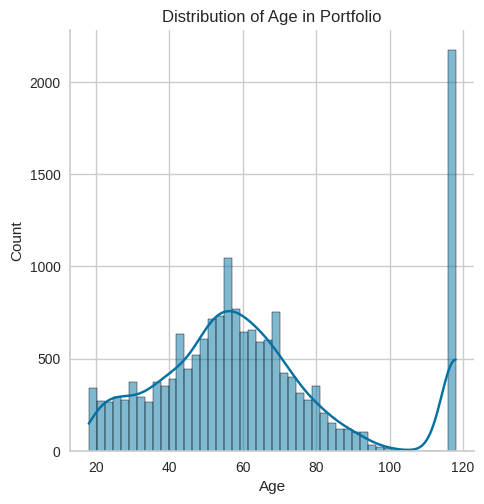

In [ ]:
sns.displot(profile['age'], kde=True)
plt.title("Distribution of Age in Portfolio")
plt.xlabel("Age")
plt.ylabel("Count");
plt.show()

Ở cột **age**, ta dễ dàng nhận thấy có một số lượng lớn outliners với giá trị là **118**

In [ ]:
profile.isna().sum()/len(profile)

gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

Xét bảng thống kê đối với bộ dữ liệu chứa **NaN** trong **gender** và **income**, ta nhận thấy sự "bất thường" ở cột **age**. Cụ thể: các khoảng phân vị đều là 118 tuổi, bên cạnh đó giá trị trung bình cũng là 118.

Những giá trị NaN chiếm tổng **xấp xỉ 25.4%** trên tổng tập dữ liệu. Con số này tuy cũng không nhỏ, nhưng vì những dòng chứa các giá trị NaN này khá là "hư cấu" nên ta có thể chọn phương án là **xóa những dòng dữ liệu này đi** để phục vụ cho các mô hình dự đoán sau này.

In [ ]:
def clean_profile(profile):

    '''
    Function to clean profile dataframe.

    INPUT - Profile dataframe

    OUTPUT - Return cleaned version of profile dataframe

    '''

    # Dropping rows containing missing values.
    profile = profile.dropna().reset_index(drop=True)

    # Rename
    profile = profile.rename(columns={'id':'person'})

    #Convert 'become_member_on' into datetime
    profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')


    return profile

profile = clean_profile(profile)
profile

,gender,age,person,became_member_on,income
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0
...,...,...,...,...,...
14820,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0
14821,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0
14822,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0
14823,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0


In [ ]:
profile.isna().sum()

gender              0
age                 0
person              0
became_member_on    0
income              0
dtype: int64

In [ ]:
profile.to_csv("cleaned_profile.csv")
files.download("cleaned_profile.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Transcript

In [ ]:
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [ ]:
transcript["event"].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [ ]:
transcript["value"]

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

Cột **value** chứa các giá trị với định dạng là **strings dictionary**, nên chúng ta cần phải chuyển đổi thành **dictionary** để xem có bao nhiêu **giá trị khóa unique** nằm trong cột này.

In [ ]:
# Hàm để trích xuất khóa từ dict of strings (value column):

def extract_keys(value):
    try:
        # Use keys() function to extract list of keys from dict.
        import ast
        return list(ast.literal_eval(value).keys())
    except (ValueError, SyntaxError):
        return []

# Apply the key extraction function to the "value" column and create a Series containing the list of keys.
keys_column = transcript['value'].apply(extract_keys)

In [ ]:
keys_column

0         [offer id]
1         [offer id]
2         [offer id]
3         [offer id]
4         [offer id]
             ...    
306529      [amount]
306530      [amount]
306531      [amount]
306532      [amount]
306533      [amount]
Name: value, Length: 306534, dtype: object

**keys_column** sẽ chứa một **Series** với **danh sách** các khóa từ các dict trong cột `value`. Nếu như chúng ta muốn sử dụng phương thức **unique()** thì yêu cầu các phần tử trong Series phải có thể băm (**hashable**).

Do danh sách (**list**) là không thể băm (**unhashable**), ta cần phải giải quyết điều này bằng cách **làm phẳng danh sách (flattening a list)**

Trong trường hợp này, ta sẽ giải quyết bằng cách cho vòng lặp qua các danh sách lồng trong **keys_column** và sau đó vòng lặp qua các khóa trong từng danh sách lồng và tạo ra một danh sách mới **flat_keys** chứa tất cả các **khóa** từ các dict, loại bỏ được các cấu trúc lồng nhau từ danh sách gốc.

In [ ]:
# Flatten the list of keys from Serial 'keys column'.
flat_keys = [key for keys in keys_column for key in keys]

# Use the unique() method to get unique values ​​from a flat list.
unique_keys = pd.Series(flat_keys).unique()

# print out
print(unique_keys)

['offer id' 'amount' 'offer_id' 'reward']


In [ ]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


Dưới đây, chúng ta sẽ sử dụng `ast.literal _eval()` để **chuyển đổi giá trị chuỗi thành 1 đối tượng**. Sau đó, kiểm tra xem giá trị trong cột `value` có phải là một chuỗi và có chứa khóa cần tim hay không không. Nếu đúng, trả về giá trị khóa cần tìm, ngược lại trả về 0.

In [ ]:
columns_to_extract_in_event = ['offer received', 'offer viewed', 'transaction', 'offer completed']
import ast

# Extract columns
for column in columns_to_extract_in_event:
    new_column_name = column
    transcript[new_column_name] = transcript['event'].apply(lambda x: 1 if column in x else 0)

# Extract offer_id from value column
transcript['offer_id'] = transcript['value'].apply(lambda x: ast.literal_eval(x)['offer_id'] if isinstance(x, str) and 'offer_id' in ast.literal_eval(x) else 0)

 # Extract offer id from value column
transcript['offer id'] = transcript['value'].apply(lambda x: ast.literal_eval(x)['offer id'] if isinstance(x, str) and 'offer id' in ast.literal_eval(x) else 0)

# Extract offer id from value column
transcript['amount'] = transcript['value'].apply(lambda x: ast.literal_eval(x)['amount'] if isinstance(x, str) and 'amount' in ast.literal_eval(x) else 0)

# Convert time unit from hours to days
transcript['time'] = transcript['time'] // 24

# Gom 2 cột offer_id và offer id lại với nhau
transcript['offer_id'] = np.where((transcript['offer_id'] == 0) & (transcript['offer id'] != 0), transcript['offer id'], transcript['offer_id'])

# xóa cột offer id
transcript = transcript.drop(columns=['offer id'])

# Tạo df mới chứa các transaction
transaction_df = transcript[transcript['transaction'] == 1]
transaction_df = transaction_df.drop(columns=['offer received', 'offer viewed', 'offer completed', 'offer_id', 'value', 'transaction'])

# Loại bỏ những dòng mà ở cột offer_id == 0 và transaction == 1
transcript = transcript[(transcript['offer_id'] != 0) & (transcript['transaction'] == 0)]

# reset lại index
transcript = transcript.reset_index(drop= True)
transaction_df = transaction_df.reset_index(drop=True)

# Deleting columns
transcript = transcript.drop(columns=['event'])
transcript = transcript.drop(columns=['value'])
transcript = transcript.drop(columns=['amount'])
transcript = transcript.drop(columns=['transaction'])



In [ ]:
transcript.isna().sum()

person             0
time               0
offer received     0
offer viewed       0
offer completed    0
offer_id           0
dtype: int64

In [ ]:
transcript

,person,time,offer received,offer viewed,offer completed,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,0,1,0,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...,...
167576,a6f84f4e976f44508c358cc9aba6d2b3,29,0,0,1,2298d6c36e964ae4a3e7e9706d1fb8c2
167577,b895c57e8cd047a8872ce02aa54759d6,29,0,0,1,fafdcd668e3743c1bb461111dcafc2a4
167578,8dda575c2a1d44b9ac8e8b07b93d1f8e,29,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
167579,8431c16f8e1d440880db371a68f82dd0,29,0,0,1,fafdcd668e3743c1bb461111dcafc2a4


In [ ]:
transcript.to_csv("compiled.csv")
files.download("compiled.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Transaction
Dataframe được tách từ transcript

In [ ]:
transaction_df

,person,event,time,amount
0,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56
2,54890f68699049c2a04d415abc25e717,transaction,0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,18.97
...,...,...,...,...
138948,b3a1272bc9904337b331bf348c3e8c17,transaction,29,1.59
138949,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,29,9.53
138950,a00058cf10334a308c68e7631c529907,transaction,29,3.61
138951,76ddbd6576844afe811f1a3c0fbb5bec,transaction,29,3.53


In [ ]:
transaction_df.isna().sum()

person    0
event     0
time      0
amount    0
dtype: int64

In [ ]:
# Merge 2 dataframe lại với nhau
transaction_df = transaction_df.merge(profile,how='left',on='person')

# Chuyển đổi cột "became_member_on" sang kiểu datetime
transaction_df['became_member_on'] = pd.to_datetime(transaction_df['became_member_on'], format='%Y-%m-%d')

# Lấy 4 ký tự đầu tiên từ năm
transaction_df['year'] = transaction_df['became_member_on'].dt.year.astype(str).str[:4]

# Drop các cột không cần thiết và các dòng chứa NaN
transaction_df = transaction_df.drop(columns = ['became_member_on', 'event', 'time'])
transaction_df = transaction_df.dropna().reset_index(drop = True)

transaction_df

,person,amount,gender,age,income,year
0,02c083884c7d45b39cc68e1314fec56c,0.83,F,20.0,30000.0,2016
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,34.56,M,42.0,96000.0,2016
2,54890f68699049c2a04d415abc25e717,13.23,M,36.0,56000.0,2017
3,b2f1cd155b864803ad8334cdf13c4bd2,19.51,F,55.0,94000.0,2017
4,fe97aa22dd3e48c8b143116a8403dd52,18.97,F,39.0,67000.0,2017
...,...,...,...,...,...,...
123952,24f56b5e1849462093931b164eb803b5,22.64,F,48.0,80000.0,2017
123953,b3a1272bc9904337b331bf348c3e8c17,1.59,M,66.0,47000.0,2018
123954,68213b08d99a4ae1b0dcb72aebd9aa35,9.53,M,52.0,62000.0,2018
123955,a00058cf10334a308c68e7631c529907,3.61,F,63.0,52000.0,2013


In [ ]:
transaction_df.isna().sum()

person    0
amount    0
gender    0
age       0
income    0
year      0
dtype: int64

In [ ]:
transaction_df.to_csv("transaction_df.csv")
files.download("transaction_df.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Compiled

In [ ]:
compiled = read_csv_from_url('https://drive.google.com/file/d/1eUPdI-PpV8tsZSTC-xgX0PANIV_2zpmG/view')

In [ ]:
compiled

,person,offer_id,time,offer received,offer viewed,offer completed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,48,1,0,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,29,1,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,15,1,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,53,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,65,1,1,1
...,...,...,...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,60,2,2,2
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,22,1,1,1
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,167,3,3,3
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,64,1,1,1


Vì chúng ta sẽ thực hiện phép tính tổng nên chúng ta muốn sửa các cột sự kiện thành giá trị 0 hoặc 1.

In [ ]:
# for all values in these columns, make sure either 0 or 1
compiled['offer received'] = compiled['offer received'].apply(lambda x: 1 if x >= 1 else 0)
compiled['offer viewed'] = compiled['offer viewed'].apply(lambda x: 1 if x >= 1 else 0)
compiled['offer completed'] = compiled['offer completed'].apply(lambda x: 1 if x >= 1 else 0)

In [ ]:
# Drop rows that contain NaN
compiled = compiled.dropna(subset=['person']).reset_index(drop=True)

In [ ]:
compiled.isna().sum()

person             0
offer_id           0
time               0
offer received     0
offer viewed       0
offer completed    0
dtype: int64

Trước khi đến bước cuối cùng trong phần này, chúng ta muốn đảm bảo sàng lọc lại một lần nữa những mã khách hàng không tồn tại trong compiled. Mục đích là để tránh xảy ra những giá trị NaN không mong muốn.

In [ ]:
compiled.nunique()

person             16994
offer_id              10
time                 198
offer received         1
offer viewed           2
offer completed        2
dtype: int64

Vì unique của **offer received = 1** nên có thể kết luận rằng tất cả các khách hàng **đều nhận được** thông tin về ưu đãi.

In [ ]:
def count_matching_unique_values(df1, df2, column_name):
    unique_values_df1 = df1[column_name].unique()
    unique_values_df2 = df2[column_name].unique()

    matching_values = set(unique_values_df1) & set(unique_values_df2)

    return len(matching_values)

matching_count = count_matching_unique_values(portfolio, compiled, 'offer_id')
print("Số lượng giá trị unique giống nhau:", matching_count)

Số lượng giá trị unique giống nhau: 10


Kiểm tra các giá trị unique ở cột "offer_id" và "person" để đánh giá được số lượng NaN trước khi chúng ta merge cả 3 df lại với nhau.

In [ ]:
profile.nunique()

gender                  3
age                    84
person              14825
became_member_on     1707
income                 91
dtype: int64

In [ ]:
matching_count = count_matching_unique_values(profile, compiled, 'person')
print("Số lượng giá trị unique giống nhau:", matching_count)

Số lượng giá trị unique giống nhau: 14820


Chúng ta thấy rằng có đến **14820** giá trị unique là giống nhau ở 2 df compiled và profile.

Như vậy, sẽ có đến 16994 - 14820 = **2174** giá trị unique khác nhau giữa 2 df

### Overall_df

Bước cuối cùng trong quá trình triển khai là xây dựng bộ dữ liệu tích hợp đầy đủ để trực quan hóa dữ liệu. Bằng cách hợp nhất tập dữ liệu **profile - portfolio - compiled**, chúng ta sẽ có tập dữ liệu đầy đủ **overall_df** chứa tất cả các tính năng có giá trị.

In [ ]:
def merge_dataframes(profile,portfolio,compiled):

    '''
    Function to merge all the dataframes together.

    Input - profile, portfolio and compiled dataframes

    Output - single dataframe

    '''

    overall = compiled.merge(portfolio,how='left',on='offer_id')

    overall = overall.merge(profile,how='left',on='person')


    return overall


overall_df = merge_dataframes(profile,portfolio,compiled)

overall_df

,person,offer_id,time,offer received,offer viewed,offer completed,reward,difficulty,duration,offer_type,offer_name,email,mobile,social,web,gender,age,became_member_on,income
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,48,1,0,1,2,10,7,discount,offer_10,1,1,0,1,M,33.0,2017-04-21,72000.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,29,1,1,0,0,0,4,informational,offer_3,1,1,0,1,M,33.0,2017-04-21,72000.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,15,1,1,0,0,0,3,informational,offer_8,1,1,1,0,M,33.0,2017-04-21,72000.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,53,1,1,1,5,5,5,bogo,offer_9,1,1,1,1,M,33.0,2017-04-21,72000.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,65,1,1,1,2,10,10,discount,offer_7,1,1,1,1,M,33.0,2017-04-21,72000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,60,1,1,1,5,5,5,bogo,offer_9,1,1,1,1,M,34.0,2017-01-23,34000.0
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,22,1,1,1,5,20,10,discount,offer_5,1,0,0,1,F,45.0,2016-11-25,62000.0
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,167,1,1,1,2,10,7,discount,offer_10,1,1,0,1,F,45.0,2016-11-25,62000.0
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,64,1,1,1,5,5,7,bogo,offer_4,1,1,0,1,F,45.0,2016-11-25,62000.0


In [ ]:
overall_df.isna().sum()

person                 0
offer_id               0
time                   0
offer received         0
offer viewed           0
offer completed        0
reward                 0
difficulty             0
duration               0
offer_type             0
offer_name             0
email                  0
mobile                 0
social                 0
web                    0
gender              8066
age                 8066
became_member_on    8066
income              8066
dtype: int64

In [ ]:
a = overall_df[overall_df['gender'].isna()]
a.nunique()

person              2174
offer_id              10
time                 140
offer received         1
offer viewed           2
offer completed        2
reward                 5
difficulty             5
duration               5
offer_type             3
offer_name            10
email                  1
mobile                 2
social                 2
web                    2
gender                 0
age                    0
became_member_on       0
income                 0
dtype: int64

Đúng như dự đoán, sự xuất hiện của **2174 giá trị NaN unique** là do sự chênh lệch giá trị ở cột person của cả 2 df

Chúng ta sẽ tách các dữ liệu NaN này sang 1 df mới tên là "**visiting_guests**" đại diện cho thông tin tham gia ưu đãi của **những khách hàng mới**.

In [ ]:
visiting_guests = overall_df[overall_df['gender'].isna()]

In [ ]:
# download df về để thuận tiện cho các thực thi sau này
visiting_guests.to_csv('visiting_guest.csv', index = False)
files.download('visiting_guest.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Còn về overall_df, ta sẽ loại bỏ đi các dòng có chứa NaN.

In [ ]:
overall_df = overall_df.dropna(subset=['gender']).reset_index(drop=True)
overall_df.isna().sum()

person              0
offer_id            0
time                0
offer received      0
offer viewed        0
offer completed     0
reward              0
difficulty          0
duration            0
offer_type          0
offer_name          0
email               0
mobile              0
social              0
web                 0
gender              0
age                 0
became_member_on    0
income              0
dtype: int64

In [ ]:
# download df về để thuận tiện cho các thực thi sau này
overall_df.to_csv('overall_df.csv', index = False)
files.download('overall_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## ANALYZING

### 1. Starbucks member growth

In [ ]:
profile = read_csv_from_url('https://drive.google.com/file/d/1LyOSiAN5tqaOK5WMOEt8uwKXavshEgcK/view')

In [ ]:
profile

,gender,age,person,became_member_on,income
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000
...,...,...,...,...,...
14820,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000
14821,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000
14822,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000
14823,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000


In [ ]:
# Chuyển đổi cột "became_member_on" sang kiểu datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y-%m-%d')

# Lấy 4 ký tự đầu tiên từ năm
profile['year'] = profile['became_member_on'].dt.year.astype(str).str[:4]

In [ ]:
mem_year = profile['year'].unique()
member_growth = pd.DataFrame({'year': mem_year})

member_growth['sum_mem_per_year'] = profile.groupby('year').size().values
member_growth = member_growth.sort_values(by='year')
member_growth

,year,sum_mem_per_year
4,2013,5599
2,2014,1597
5,2015,3669
3,2016,3024
0,2017,274
1,2018,662


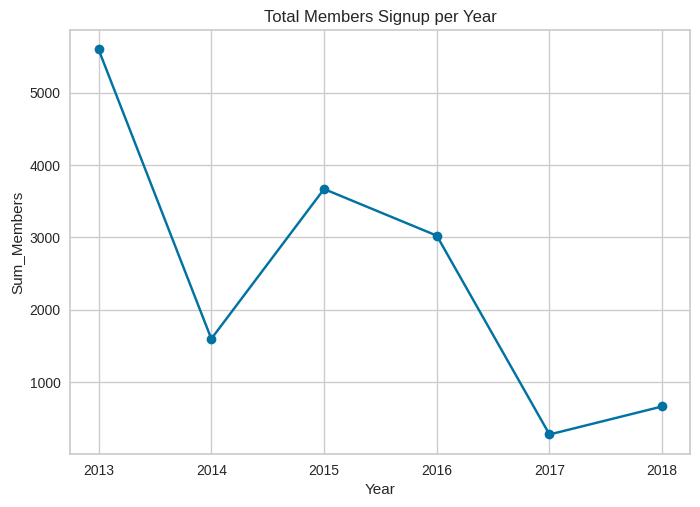

In [ ]:
plt.plot(member_growth['year'], member_growth['sum_mem_per_year'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Sum_Members')
plt.title('Total Members Signup per Year')
plt.show()

Chúng ta có thể nhận thấy rằng số khách hàng đăng ký làm thành viên của Starbucks đạt cao nhất vào năm 2013, và sau đó lại **giảm gấp 2 lần vào năm 2014** và vào **năm 2017**.

Bởi lẽ bộ dữ liệu ghi nhận của Starbuck chỉ dừng lại ở năm 2018, nhưng ta cũng có thể đánh giá rằng **các chương trình ưu đãi** của Starbucks diễn ra vào **năm 2013, 2015 và 2016** diễn ra khá tốt, đã **thu hút được 1 lượng lớn các khách hàng mới**.

Tuy nhiên, Starbucks cũng cần **xem xét** lại các **chương trình quảng cáo, ưu đãi vào năm 2014 và 2017** để tìm phương án cải thiện


### Starbucks member spending

In [ ]:
transaction = read_csv_from_url('https://drive.google.com/file/d/1oOKz09E0CAI7jzTM4Ehyjt9bwOHnYSAp/view')

In [ ]:
transaction

,person,amount,gender,age,income,year
0,02c083884c7d45b39cc68e1314fec56c,0.83,F,20,30000,2016
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,34.56,M,42,96000,2016
2,54890f68699049c2a04d415abc25e717,13.23,M,36,56000,2017
3,b2f1cd155b864803ad8334cdf13c4bd2,19.51,F,55,94000,2017
4,fe97aa22dd3e48c8b143116a8403dd52,18.97,F,39,67000,2017
...,...,...,...,...,...,...
123952,24f56b5e1849462093931b164eb803b5,22.64,F,48,80000,2017
123953,b3a1272bc9904337b331bf348c3e8c17,1.59,M,66,47000,2018
123954,68213b08d99a4ae1b0dcb72aebd9aa35,9.53,M,52,62000,2018
123955,a00058cf10334a308c68e7631c529907,3.61,F,63,52000,2013


In [ ]:
mem_value = transaction.groupby('year')['amount'].sum().reset_index()
mem_value.columns=['Year', 'Total_spending']
mem_value


,Year,Total_spending
0,2013,23375.98
1,2014,55311.60
2,2015,245725.55
3,2016,519551.67
4,2017,658287.36
5,2018,232690.24


In [ ]:
mean_mem_value = transaction.groupby('year')['amount'].mean().reset_index()
mean_mem_value.columns=['Year', 'Average_spending']
mean_mem_value

,Year,Average_spending
0,2013,6.859149
1,2014,6.759330
2,2015,13.982335
3,2016,16.669929
4,2017,14.933585
5,2018,11.905968


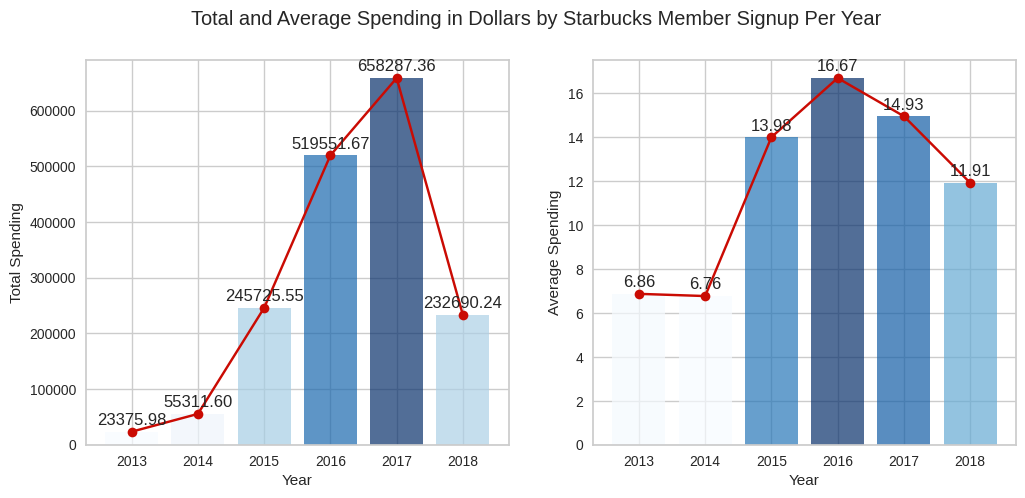

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.cm import Blues
from matplotlib.colors import Normalize

# Chuẩn hóa giá trị cột "Total_spending" để nằm trong khoảng từ 0 đến 1
norm1 = Normalize(vmin=mem_value['Total_spending'].min(), vmax=mem_value['Total_spending'].max())

# Chuẩn hóa giá trị cột "Average_spending" để nằm trong khoảng từ 0 đến 1
norm2 = Normalize(vmin=mean_mem_value['Average_spending'].min(), vmax=mean_mem_value['Average_spending'].max())

# Tạo đối tượng Figure và trục (axes) với 2 cột
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Biểu đồ 1: Total Spending
bars1 = ax1.bar(mem_value['Year'], mem_value['Total_spending'], color=Blues(norm1(mem_value['Total_spending'])), alpha=0.7, label='Total Spending')
line1 = ax1.plot(mem_value['Year'], mem_value['Total_spending'], color='r', marker='o')[0]
for i, value in enumerate(mem_value['Total_spending']):
    ax1.annotate(f'{value:.2f}', (mem_value['Year'][i], value), textcoords="offset points", xytext=(0, 5), ha='center')
ax1.set_ylabel('Total Spending')

# Biểu đồ 2: Average Spending
bars2 = ax2.bar(mean_mem_value['Year'], mean_mem_value['Average_spending'], color=Blues(norm2(mean_mem_value['Average_spending'])), alpha=0.7, label='Average Spending')
line2 = ax2.plot(mean_mem_value['Year'], mean_mem_value['Average_spending'], color='r', marker='o')[0]
for i, value in enumerate(mean_mem_value['Average_spending']):
    ax2.annotate(f'{value:.2f}', (mean_mem_value['Year'][i], value), textcoords="offset points", xytext=(0, 5), ha='center')
ax2.set_ylabel('Average Spending')

# Thiết lập chung cho cả hai trục
for ax in [ax1, ax2]:
    ax.set_xlabel('Year')

# Đặt tiêu đề cho toàn bộ biểu đồ
fig.suptitle('Total and Average Spending in Dollars by Starbucks Member Signup Per Year')

# Hiển thị biểu đồ
plt.show()



Ở **biểu đồ 1** cho thấy **tổng số tiền các thành viên của Starbucks đã chi trả theo từng năm, từ 2014 đến 2017 tăng mạnh**, xấp xỉ 29 lần. Điều này đồng nghĩa với **doanh thu** của Starbucks ở những năm này cũng **đồng biến**.

So sánh với **biểu đồ 2**, các giá trị doanh thu trung bình theo từng năm cho ta thấy rằng **số tiền giao dịch vào các năm 2014 đến 2016 rải đều theo từng nhóm khách hàng thành viên** của Starbucks. Tuy tổng doanh thu vào **năm 2017** là cao nhất, nhưng giá trị trung bình của nó lại thấp hơn 2016, điều này cho thấy **doanh thu tập trung vào 1 số lượng giao dịch của nhóm đối tượng khách hàng thành viên cụ thể**.  

Bên cạnh đó, mặc dù Starbucks **chưa ổn định** được phương hướng phát triển, mở rộng, **thu hút các nhóm đối tượng khách hàng mới**, nhưng không thể phũ nhận rằng Starbucks đã **làm rất tốt trong việc "giữ chân" được các nhóm khách hàng tiềm năng** của mình. Điều này thể hiện rất rõ qua phần lớn doanh thu của Starbucks đến từ các nhóm khách hàng thân thiết và có thu nhập cao.



In [ ]:
# Tạo DataFrame mới với cột 'Year' và 'Sale Growth Rate'
sale_growth = pd.DataFrame(columns=['Year', 'Sale Growth Rate'])

# Tốc độ tăng trưởng năm n = (Doanh thu năm n – Doanh thu năm n-1) : (Doanh thu năm n-1) x 100%

# Tính toán và thêm dữ liệu vào DataFrame
for i in range(1, len(mem_value)):
    year = mem_value.loc[i, 'Year']
    growth_rate = ((mem_value.loc[i, 'Total_spending'] - mem_value.loc[i-1, 'Total_spending']) / mem_value.loc[i-1, 'Total_spending']) * 100
    row_data = {'Year': year, 'Sale Growth Rate': growth_rate}
    sale_growth = pd.concat([sale_growth, pd.DataFrame([row_data])], ignore_index=True)

sale_growth



,Year,Sale Growth Rate
0,2014,136.617246
1,2015,344.256811
2,2016,111.435754
3,2017,26.702963
4,2018,-64.652179


### Starbucks members spending by Age and Income

Tiếp đến, chúng ta sẽ sử dụng quy tắc **Sturges** - là một tiêu chí được sử dụng để **xác định số lượng các lớp** hoặc khoảng cần thiết **để biểu thị bằng đồ họa một tập hợp dữ liệu thống kê**, dựa trên **số lượng mẫu x** cho phép tìm **số lượng lớp** và **biên độ phạm vi** của chúng.

Quy tắc này được ban hành vào năm 1926 bởi nhà toán học người Đức Herbert Sturges.

In [ ]:
transaction = read_csv_from_url('https://drive.google.com/file/d/1oOKz09E0CAI7jzTM4Ehyjt9bwOHnYSAp/view')

In [ ]:
transaction['person'].nunique()

14492

In [ ]:
int(np.ceil(np.log2(14492)) + 1)

15

Số lượng lớp tối ưu sẽ (log2N + 1) là 15 bộ. Như vậy, chúng ta sẽ chia "age" thành 15 lớp như sau:

In [ ]:
bins= [18,24,29,35,40,46,51,57,62,68,73,79,84,90,95,102]
labels = ['18-23','24-28','29-34','35-39','40-45','45-50','51-56',\
          '57-61','62-67','68-72','73-78','79-83','84-89','90-94','95-101']
transaction['age_group']=pd.cut(transaction['age'], bins=bins, labels=labels,right=False)

In [ ]:
transaction.groupby(['age_group'])['amount'].sum()

age_group
18-23      61711.58
24-28      58849.81
29-34      70381.91
35-39      95743.48
40-45     133467.80
45-50     150522.56
51-56     267417.85
57-61     226501.45
62-67     237465.54
68-72     143180.97
73-78     128005.82
79-83      76856.81
84-89      50139.64
90-94      25010.82
95-101      9686.36
Name: amount, dtype: float64

In [ ]:
transaction.groupby(['age_group'])['person'].nunique()

age_group
18-23      732
24-28      706
29-34      804
35-39      831
40-45     1219
45-50     1305
51-56     2076
57-61     1716
62-67     1803
68-72     1145
73-78      967
79-83      543
84-89      380
90-94      196
95-101      69
Name: person, dtype: int64

In [ ]:
tran=transaction.groupby(['age_group','age'])['amount'].sum()/transaction.groupby(['age_group','age'])['person'].nunique()
avg_spend_by_age=pd.DataFrame(tran).reset_index()
avg_spend_by_age.columns =['age_group','age','avg_dollars_spent']
avg_spend_by_age

,age_group,age,avg_dollars_spent
0,18-23,18,81.631449
1,18-23,19,71.889778
2,18-23,20,78.044361
3,18-23,21,98.846357
4,18-23,22,94.900154
...,...,...,...
1255,95-101,97,176.661667
1256,95-101,98,74.076000
1257,95-101,99,168.376000
1258,95-101,100,169.395000


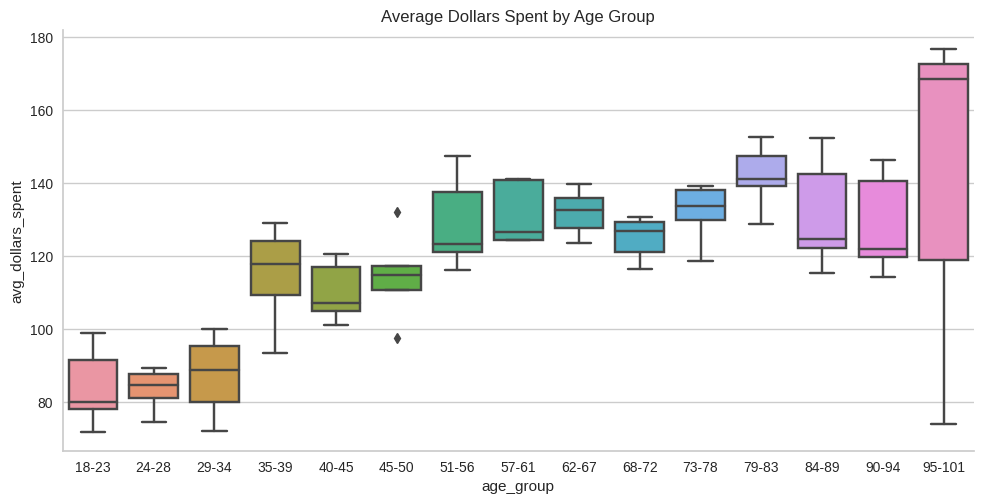

In [ ]:
sns.catplot(data=avg_spend_by_age, x="age_group", y="avg_dollars_spent",kind='box', height=5, aspect=2)
plt.title("Average Dollars Spent by Age Group")
plt.show()

In [ ]:
correlation = transaction['age'].corr(transaction['income'])
correlation

0.2826765073812592

Chi tiêu trung bình của Starbucks tăng theo độ tuổi của khách hàng. Trung bình, khách hàng ở **độ tuổi 51-67** **chi tiêu nhiều hơn 50% so với những người ở độ tuổi 18-34**. Mặc dù tuổi tác có mối quan hệ tuyến tính dương yếu với thu nhập (**r = 0,28**), nhưng ta có thể thấy rằng mức chi tiêu trung bình tăng theo nhóm tuổi.

Dựa trên mô hình này, Starbucks nên gửi các **ưu đãi hấp dẫn khách hàng dựa trên nhóm tuổi của họ**. Chẳng hạn như, đối với nhóm **khách hàng trẻ, quan tâm đến chi phí** (từ 18-34 tuổi), ta có thể ưu tiên các **mã giảm giá**. Bên cạnh đó, **tăng phần thưởng** cho **khách hàng lớn tuổi** nhằm khuyến khích giá trị đơn hàng trung bình thường xuyên hơn hoặc cao hơn (từ 35 tuổi trở lên).

### Starbucks members spending by Age and Gender

In [ ]:
transaction = read_csv_from_url('https://drive.google.com/file/d/1oOKz09E0CAI7jzTM4Ehyjt9bwOHnYSAp/view')

In [ ]:
#Rebinning into 5 groups
bins= [18,34,51,68,84,102]
labels = ['18-34','35-50','51-67','68-83','84-101']
transaction['age_group2']=pd.cut(transaction['age'], bins=bins, labels=labels,right=False)

In [ ]:
tran=transaction.groupby(['age_group2','gender'])['amount'].sum()/transaction.groupby(['age_group2','gender'])['person'].nunique()
avg_spend_by_age=pd.DataFrame(tran).reset_index()
avg_spend_by_age.columns =['age_group2','gender','avg_dollars_spent']
avg_spend_by_age=avg_spend_by_age[avg_spend_by_age['gender']!='O']
avg_spend_by_age

,age_group2,gender,avg_dollars_spent
0,18-34,F,121.583530
1,18-34,M,70.379615
3,35-50,F,136.291546
4,35-50,M,97.577405
6,51-67,F,152.437556
7,51-67,M,112.396503
9,68-83,F,147.958793
10,68-83,M,115.788862
12,84-101,F,138.403932
13,84-101,M,121.433478


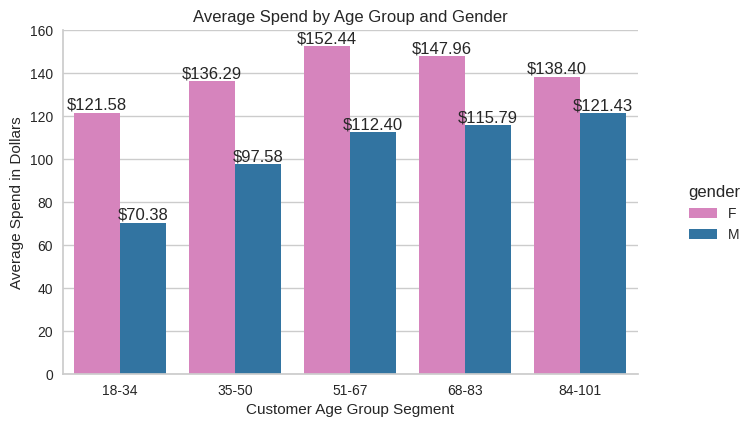

In [ ]:
g = sns.catplot(
    data=avg_spend_by_age, kind="bar",
    x="age_group2", y="avg_dollars_spent", hue="gender",palette=sns.color_palette(['tab:pink', 'tab:blue']),
    dodge=True)

g.fig.set_size_inches(8, 5)
g.fig.subplots_adjust(top=0.81, right=0.86)

ax = g.facet_axis(0, 0)
for c in ax.containers:
    labels = [f'${(v.get_height()):.2f}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')
g.set_axis_labels("")
g.set(xlabel = "Customer Age Group Segment",ylabel ="Average Spend in Dollars")
plt.title("Average Spend by Age Group and Gender")
# plt.xticks(rotation=45)
plt.show()

Nhóm đối tượng khách hàng thân thiết là giới tính nữ, có xu hướng giao dịch nhiều hơn giới tính nam trong mọi độ tuổi.

VÌ vậy, Starbucks cần **đẩy mạnh các dịch vụ, chương trình ưu đãi để có thể thu hút các khách hàng nữ nhiều hơn**.

### Total Loss

In [ ]:
overall_df = read_csv_from_url('https://drive.google.com/file/d/10Qcxsjq0EcsKDpvGXYxucZ8E8SMoEn_f/view')

Đối với cách hoạt động của mỗi ưu đãi, chúng ta có thể đánh giá được mức độ thiệt hại / lợi nhuận cho công ty. Bởi lẽ các ưu đãi giảm giá đều mang lại số lượng phần thưởng cho khách hàng (reward), hay cụ thể hơn là công ty sẽ phải bỏ ra một khoảng tiền để marketing ưu đãi (thông qua các phương thức như email, web, v..v) đến với khách hàng. Vì vậy, nếu các ưu đãi không được xem và hoàn thành, điều đó thực sự có thể gây thua lỗ cho công ty.

Vì vậy, **tổng thiệt hại cho mỗi ưu đãi và tính toán từng tỷ lệ *có/không được* xem trước khi hoàn thàn**h cho công ty.

In [ ]:
# Tính toán total_completed khi offer completed == 1
completed = overall_df[overall_df['offer completed'] == 1].groupby(['offer_name', 'offer_type']).size().reset_index(name='total_completed')

# Tính toán total_completed_without_view và loss (Tổng thiệt hại = Tổng số tiền cty bỏ ra (reward) và không được khách hàng completed($))
completed_not_view = overall_df[(overall_df['offer viewed'] == 0) & (overall_df['offer completed'] == 1)].groupby(['offer_name', 'offer_type']).agg(
    total_completed_without_view=('offer_name', 'size'),
    loss=('reward', 'sum')
).reset_index()

# Merge hai DataFrame theo cột offer_id
merged_df = pd.merge(completed, completed_not_view, on=['offer_name', 'offer_type'], how='inner')

# Tính toán các tỷ lệ
merged_df['total_completed_without_view_ratio'] = (merged_df['total_completed_without_view'] / merged_df['total_completed']) * 100
merged_df['total_completed_with_view_ratio'] = 100 - merged_df['total_completed_without_view_ratio']

# Lựa chọn các cột cần thiết
result_df = merged_df[['offer_name', 'offer_type', 'total_completed', 'total_completed_without_view',
                        'total_completed_without_view_ratio', 'total_completed_with_view_ratio', 'loss']]

# Sắp xếp theo total_completed_without_view_ratio giảm dần
completed_without_viewed_df = result_df.sort_values(by='total_completed_without_view_ratio', ascending=False)

# In ra kết quả
completed_without_viewed_df

,offer_name,offer_type,total_completed,total_completed_without_view,total_completed_without_view_ratio,total_completed_with_view_ratio,loss
4,offer_5,discount,2944,1492,50.679348,49.320652,7460
3,offer_4,bogo,3627,1230,33.912324,66.087676,6150
1,offer_10,discount,3383,1048,30.978422,69.021578,2096
0,offer_1,bogo,3146,333,10.584870,89.415130,3330
5,offer_6,discount,4167,105,2.519798,97.480202,315
7,offer_9,bogo,3562,81,2.274003,97.725997,405
6,offer_7,discount,4248,94,2.212806,97.787194,188
2,offer_2,bogo,2865,60,2.094241,97.905759,600


Ta có thể thấy **offer_3** và **offer_8** không nằm trong bảng dữ liệu trên. Điều này đồng nghĩa rằng ưu đãi **informational** của Starbucks hầu như **không có khách hàng nào hoàn thành**.

Bên cạnh đó, đối với 2 loại ưu đãi này, cả Starbucks và khách hàng đều không cần phải bỏ ra thêm chi phí nào cả. Vì vậy, sự không tồn tại của cả 2 offer_3 và offer_8 cũng không ảnh hưởng đến tổng thiệt hại của công ty. Chúng ta có thể bỏ qua.

In [ ]:
# Tính tổng thất thu của công ty và tổng lượt khôgn xem trước khi hoàn thành theo từng loại ưu đãi
each_offer_type_loss = completed_without_viewed_df.groupby(['offer_type'])['loss', 'total_completed_without_view'].sum()
each_offer_type_loss

<ipython-input-72-8caed36f4420>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  each_offer_type_loss = completed_without_viewed_df.groupby(['offer_type'])['loss', 'total_completed_without_view'].sum()


,loss,total_completed_without_view
offer_type,,
bogo,10485,1704
discount,10059,2739


In [ ]:
each_offer_type_loss.describe()

,loss,total_completed_without_view
count,2.000000,2.000000
mean,10272.000000,2221.500000
std,301.227489,731.855519
min,10059.000000,1704.000000
25%,10165.500000,1962.750000
50%,10272.000000,2221.500000
75%,10378.500000,2480.250000
max,10485.000000,2739.000000


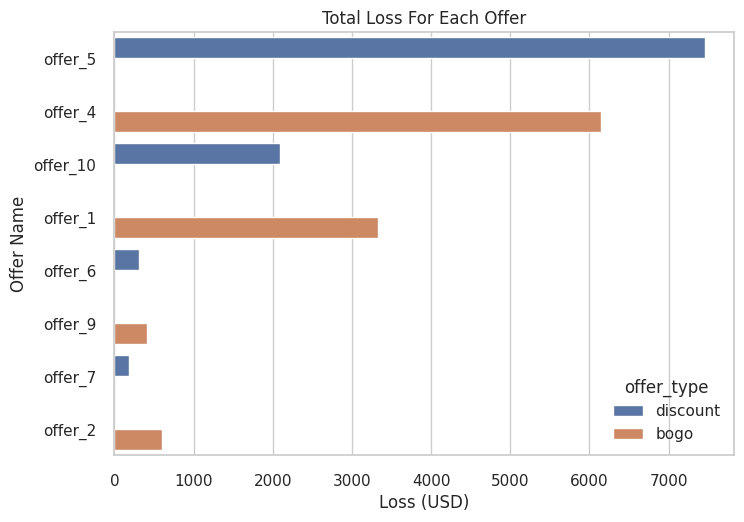

In [ ]:
sns.barplot(x='loss', y='offer_name', hue='offer_type', data=completed_without_viewed_df)

plt.xlabel('Loss (USD)')
plt.ylabel('Offer Name')
plt.title('Total Loss For Each Offer')

plt.show()

Nhìn chung, chúng ta thấy rằng các ưu đãi BOGO tạo ra nhiều tổn thất hơn so với các ưu đãi discount. Điều này có ý nghĩa vì phần thưởng của BOGO thường **lớn hơn** phần thưởng của Giảm giá. Điều này có thể được lý giải như sau:

Với chương trình giảm giá, Starbucks chỉ phải chịu **một phần chi phí của sản phẩm** được giảm giá. Ví dụ, với chương trình giảm giá 50% cho tất cả đồ uống, cửa hàng chỉ phải chịu 50% chi phí của mỗi sản phẩm được bán ra.

Với chương trình mua 1 tặng 1, Starbucks phải chịu **toàn bộ chi phí của sản phẩm được tặng**. Ví dụ, với chương trình mua 1 tặng 1 cho đồ uống trà sữa size M, cửa hàng phải **chịu thêm 100%** chi phí của một sản phẩm trà sữa size M cho mỗi sản phẩm được bán ra. Điều này có thể làm giảm lợi nhuận của cửa hàng.

Đến đây, chúng ta có thể đưa ra được những kết luận như sau:

+ Về mặt lợi nhuận, chương trình ưu đãi giảm giá sẽ đem lại lợi nhuận cao hơn cho cửa hàng so với BOGO.


+ Tuy nhiên, trong một số trường hợp, BOGO có thể đem lại lợi nhuận cao hơn cho cửa hàng. Ví dụ, nếu BOGO được áp dụng cho sản phẩm mới, cửa hàng có thể **thu hút được nhiều khách hàng mới và tăng doanh số bán hàng đáng kể**. Do đó, **lợi nhuận** mà cửa hàng thu được từ BOGO **có thể cao hơn** chi phí mà cửa hàng phải chịu. Ngoài ra trong trường hợp thanh lý hàng tồn kho, BOGO cũng đem lại lợi ích cho cửa hàng.  BOGO không chỉ giúp cửa hàng **giảm lãng phí** và tăng doanh số bán hàng mà còn đóng vai trò quan trọng trong việc quản lý hàng hóa sắp hết hạn, đảm bảo rằng chúng được tiêu thụ một cách an toàn và có hiệu quả.

+ Việc lựa chọn chương trình khuyến mãi nào phụ thuộc vào nhiều yếu tố khác nhau, bao gồm mục tiêu của Starbucks, đối tượng khách hàng và nhu cầu của khách hàng. Nếu cửa hàng muốn tối đa hóa lợi nhuận, ưu đãi giảm giá là lựa chọn phù hợp hơn. Nếu cửa hàng muốn thu hút khách hàng mới và tăng doanh số bán hàng, BOGO có thể là lựa chọn phù hợp hơn.

### Channel Response Rate

In [ ]:
overall_df = read_csv_from_url('https://drive.google.com/file/d/10Qcxsjq0EcsKDpvGXYxucZ8E8SMoEn_f/view')

In [ ]:
emails_completed=overall_df[(overall_df['offer completed']== 1) \
                        & (overall_df['email']==1)]['email'].count()

emails_received=overall_df[(overall_df['offer received']==1)\
& (overall_df['email']==1)]['email'].count()

email_response_rate=round((emails_completed/emails_received*100),1)
email_response_rate

50.6

In [ ]:
web_completed=overall_df[(overall_df['offer completed']== 1) \
                        & (overall_df['web']==1)]['web'].count()

web_received=overall_df[(overall_df['offer received']==1)\
& (overall_df['web']==1)]['web'].count()

web_response_rate=round((web_completed/web_received*100),1)
web_response_rate

56.2

In [ ]:
mobile_completed=overall_df[(overall_df['offer completed']== 1) \
                        & (overall_df['mobile']==1)]['mobile'].count()

mobile_received=overall_df[(overall_df['offer received']==1)\
& (overall_df['mobile']==1)]['mobile'].count()

mobile_response_rate=round((mobile_completed/mobile_received*100),1)
mobile_response_rate

50.4

In [ ]:
social_completed=overall_df[(overall_df['offer completed']== 1) \
                        & (overall_df['social']==1)]['social'].count()

social_received=overall_df[(overall_df['offer received']==1)\
& (overall_df['social']==1)]['social'].count()

social_response_rate=round((social_completed/social_received*100),1)
social_response_rate

54.4

In [ ]:
channel_response_rate={'email':email_response_rate,
                      'mobile':mobile_response_rate,
                      'web':web_response_rate,
                      'social':social_response_rate}
channel_response_rate

{'email': 50.6, 'mobile': 50.4, 'web': 56.2, 'social': 54.4}

In [ ]:
channel_response_rate_df=pd.DataFrame.from_dict(channel_response_rate,orient='index').reset_index()
channel_response_rate_df.columns =['channels','channel_response_rate']
channel_response_rate_df

,channels,channel_response_rate
0,email,50.6
1,mobile,50.4
2,web,56.2
3,social,54.4


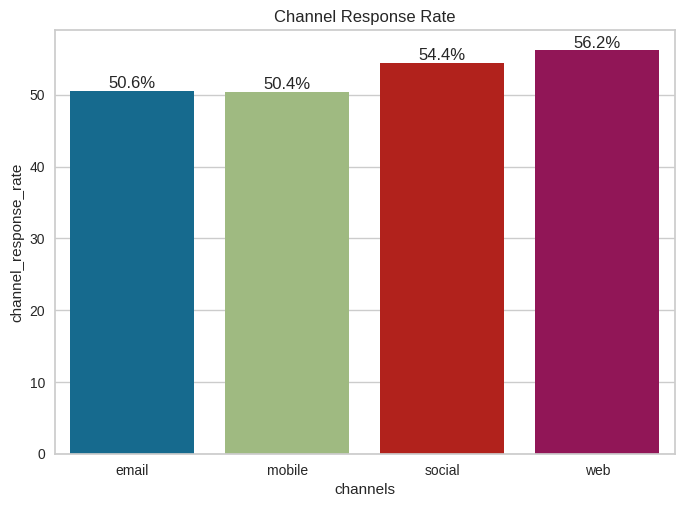

In [ ]:
groupedvalues = channel_response_rate_df.groupby('channels').sum().reset_index()
ax=sns.barplot(data=groupedvalues, x="channels",  y="channel_response_rate",errwidth=0)
plt.title('Channel Response Rate')
ax.bar_label(ax.containers[0],fmt='%1.1f%%')
plt.show()

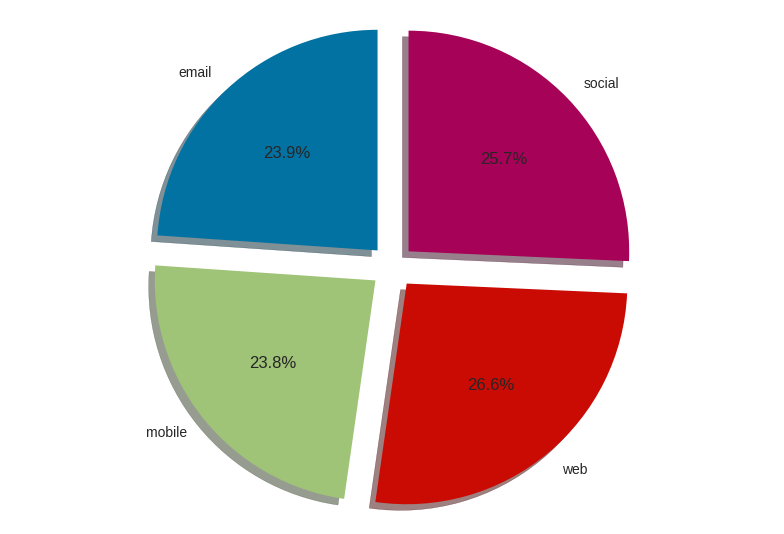

In [ ]:
# Pie chart
labels = channel_response_rate_df['channels'].tolist()
sizes = channel_response_rate_df['channel_response_rate'].tolist()
# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0.1, 0.1, 0.1, 0.1)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
plt.tight_layout()
plt.show()

Ta dễ dàng nhận thấy rằng số lượng cũng như phần trăm **hoàn thành offer trên phương thức web là cao nhất**, và **thấp nhất là trên phương thức điện thoại**. Mặc dù vậy, phần trăm hoàn thành trên cả 4 phương thức là chênh lệch không nhiều, chứng tỏ cả 4 phương thức đều có tính hiệu quả cao.

### Comparing Same Difficulty and Reward

In [ ]:
overall_df = read_csv_from_url('https://drive.google.com/file/d/10Qcxsjq0EcsKDpvGXYxucZ8E8SMoEn_f/view')
overall_df

,person,offer_id,time,offer received,offer viewed,offer completed,reward,difficulty,duration,offer_type,offer_name,email,mobile,social,web,gender,age,became_member_on,income
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,48,1,0,1,2,10,7,discount,offer_10,1,1,0,1,M,33.0,2017-04-21,72000.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,29,1,1,0,0,0,4,informational,offer_3,1,1,0,1,M,33.0,2017-04-21,72000.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,15,1,1,0,0,0,3,informational,offer_8,1,1,1,0,M,33.0,2017-04-21,72000.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,53,1,1,1,5,5,5,bogo,offer_9,1,1,1,1,M,33.0,2017-04-21,72000.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,65,1,1,1,2,10,10,discount,offer_7,1,1,1,1,M,33.0,2017-04-21,72000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55217,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,60,1,1,1,5,5,5,bogo,offer_9,1,1,1,1,M,34.0,2017-01-23,34000.0
55218,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,22,1,1,1,5,20,10,discount,offer_5,1,0,0,1,F,45.0,2016-11-25,62000.0
55219,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,167,1,1,1,2,10,7,discount,offer_10,1,1,0,1,F,45.0,2016-11-25,62000.0
55220,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,64,1,1,1,5,5,7,bogo,offer_4,1,1,0,1,F,45.0,2016-11-25,62000.0


In [ ]:
df = overall_df[overall_df['offer completed'] == 1] \
    .groupby(['offer_type', 'difficulty', 'reward', 'duration'])[['email', 'mobile', 'social', 'web']].count()

df = df.reset_index()
df_a = pd.DataFrame(df)
df_a = df_a.drop(columns = ['mobile', 'web', 'social'])
df_a = df_a.rename(columns = {'email':'Number of Offers Completed'})
df_a

,offer_type,difficulty,reward,duration,Number of Offers Completed
0,bogo,5,5,5,3562
1,bogo,5,5,7,3627
2,bogo,10,10,5,2865
3,bogo,10,10,7,3146
4,discount,7,3,7,4167
5,discount,10,2,7,3383
6,discount,10,2,10,4248
7,discount,20,5,10,2944


In [ ]:
df2 = overall_df[overall_df['offer received'] == 1] \
    .groupby(['offer_type', 'difficulty', 'reward', 'duration'])[['email', 'mobile', 'social', 'web']].count()

df2 = df2.reset_index()
df_b = pd.DataFrame(df2)
df_b = df_b.drop(columns = ['mobile', 'web', 'social'])
df_b = df_b.rename(columns = {'email':'Number of Offers Received'})
df_b

,offer_type,difficulty,reward,duration,Number of Offers Received
0,bogo,5,5,5,5445
1,bogo,5,5,7,5542
2,bogo,10,10,5,5511
3,bogo,10,10,7,5564
4,discount,7,3,7,5507
5,discount,10,2,7,5480
6,discount,10,2,10,5544
7,discount,20,5,10,5588
8,informational,0,0,3,5517
9,informational,0,0,4,5524


In [ ]:
#inner join df_a and df_b on index
response=pd.merge(df_a, df_b, left_index=True, right_index=True)

In [ ]:
response=response.drop(columns=['offer_type_y', 'difficulty_y','reward_y','duration_y'])\
.rename(columns={"offer_type_x": "offer_type",\
                             "difficulty_x": "difficulty",\
                             "reward_x": "reward",\
                             "duration_x":"duration"})
response['Percent of Offers Completed/Offers Received']=\
round((response['Number of Offers Completed']/response['Number of Offers Received']*100),1)

response

,offer_type,difficulty,reward,duration,Number of Offers Completed,Number of Offers Received,Percent of Offers Completed/Offers Received
0,bogo,5,5,5,3562,5445,65.4
1,bogo,5,5,7,3627,5542,65.4
2,bogo,10,10,5,2865,5511,52.0
3,bogo,10,10,7,3146,5564,56.5
4,discount,7,3,7,4167,5507,75.7
5,discount,10,2,7,3383,5480,61.7
6,discount,10,2,10,4248,5544,76.6
7,discount,20,5,10,2944,5588,52.7


In [ ]:
response['Offer Type Variant']=response['offer_type'].str.upper()\
+": "+ "Spend: "+response['difficulty'].astype(str)\
+", Reward: "+response['reward'].astype(str)\
+", Duration: "+response['duration'].astype(str)
response

,offer_type,difficulty,reward,duration,Number of Offers Completed,Number of Offers Received,Percent of Offers Completed/Offers Received,Offer Type Variant
0,bogo,5,5,5,3562,5445,65.4,"BOGO: Spend: 5, Reward: 5, Duration: 5"
1,bogo,5,5,7,3627,5542,65.4,"BOGO: Spend: 5, Reward: 5, Duration: 7"
2,bogo,10,10,5,2865,5511,52.0,"BOGO: Spend: 10, Reward: 10, Duration: 5"
3,bogo,10,10,7,3146,5564,56.5,"BOGO: Spend: 10, Reward: 10, Duration: 7"
4,discount,7,3,7,4167,5507,75.7,"DISCOUNT: Spend: 7, Reward: 3, Duration: 7"
5,discount,10,2,7,3383,5480,61.7,"DISCOUNT: Spend: 10, Reward: 2, Duration: 7"
6,discount,10,2,10,4248,5544,76.6,"DISCOUNT: Spend: 10, Reward: 2, Duration: 10"
7,discount,20,5,10,2944,5588,52.7,"DISCOUNT: Spend: 20, Reward: 5, Duration: 10"


In [ ]:
response=response.drop(columns=['offer_type', 'difficulty','reward','duration'])
response

,Number of Offers Completed,Number of Offers Received,Percent of Offers Completed/Offers Received,Offer Type Variant
0,3562,5445,65.4,"BOGO: Spend: 5, Reward: 5, Duration: 5"
1,3627,5542,65.4,"BOGO: Spend: 5, Reward: 5, Duration: 7"
2,2865,5511,52.0,"BOGO: Spend: 10, Reward: 10, Duration: 5"
3,3146,5564,56.5,"BOGO: Spend: 10, Reward: 10, Duration: 7"
4,4167,5507,75.7,"DISCOUNT: Spend: 7, Reward: 3, Duration: 7"
5,3383,5480,61.7,"DISCOUNT: Spend: 10, Reward: 2, Duration: 7"
6,4248,5544,76.6,"DISCOUNT: Spend: 10, Reward: 2, Duration: 10"
7,2944,5588,52.7,"DISCOUNT: Spend: 20, Reward: 5, Duration: 10"


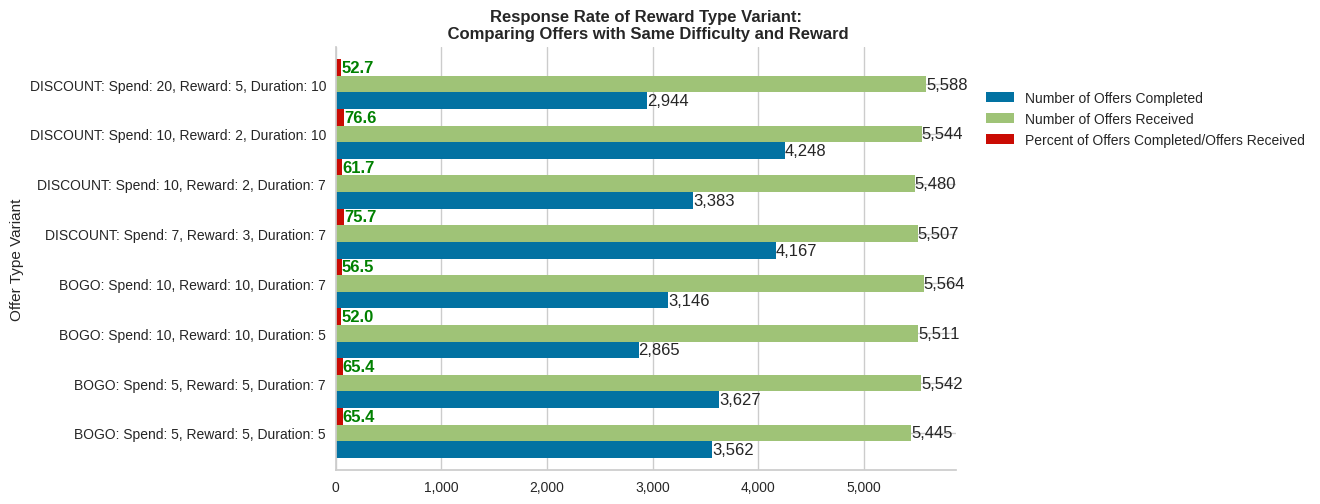

In [ ]:
from matplotlib.ticker import StrMethodFormatter

#Offer type variant with same difficulty and reward perform better with longer time durations.
response.set_index('Offer Type Variant', inplace=True)
ax = response.plot(kind="barh", width=1, legend=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.bar_label(ax.containers[0], fmt='{:,.0f}')
ax.bar_label(ax.containers[1], fmt='{:,.0f}')
ax.bar_label(ax.containers[2], fmt='{:,.1f}', label_type='edge', color='green', fontsize=12, weight='bold')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.legend(response.columns, loc=(1.04, .75))
plt.title('Response Rate of Reward Type Variant:\n Comparing Offers with Same Difficulty and Reward', weight='bold')
plt.show()


Phần lớn **số lượng received và completed** là cho các ưu đãi tặng thưởng **giảm giá**. Các ưu đãi **BOGO hoạt động tốt nhất là difficulty (spend) 5 USD và phần thưởng 5 USD**. 3 biến thể ưu đãi **hoạt động kém nhất là giảm giá với mức spend 20 USD và ưu đãi BOGO là 10 USD.**

Bên cạnh đó, **ưu đãi nào càng kéo dài** thì **khách hàng** có xu hướng tiếp nhận và hoàn thành nó tốt hơn những ưu đãi ngắn hạn.

# CUSTOMER SEGEMENTATION

In [ ]:
# Taking data in drive
transaction_df = read_csv_from_url('https://drive.google.com/file/d/1tPai4zOLmgo7u2wrJ2z_JCcWQHXTLUG3/view')
transaction_df.head()

,Unnamed: 0,person,event,time,amount
0,0,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83
1,1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56
2,2,54890f68699049c2a04d415abc25e717,transaction,0,13.23
3,3,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51
4,4,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,18.97


## RFM Analysis (Recency, Frequency, Monetary)

Mô hình phân tích RFM là một phương pháp phân loại và phân tích khách hàng dựa trên ba yếu tố chính:

+ **Recency (R)**: Thời điểm gần nhất mà một khách hàng đã thực hiện giao dịch. Nếu Recency cao, điều này có nghĩa là khách hàng đã lâu không thực hiện giao dịch, và nếu Recency thấp, điều này cho thấy khách hàng gần đây vẫn tương tác đều đặn với chúng ta.

+ **Frequency (F)**: Số lần khách hàng đã thực hiện giao dịch trong một khoảng thời gian nhất định. Nếu Frequency cao, có nghĩa là khách hàng mua hàng nhiều lần, và nếu Frequency thấp, có nghĩa là khách hàng ít khi mua hàng.

+ **Monetary (M)**: Tổng giá trị của các giao dịch đã thực hiện bởi khách hàng. Nếu Monetary cao, có nghĩa là khách hàng đã chi tiêu nhiều cho sản phẩm của chúng ta.

Ta sẽ thực hiện các bước phân tích như sau:

1. Xác định thời điểm giao dịch gần đây nhất, tổng số lần mua, tổng số tiền chi tiêu của từng khách hàng.

2. Chấm điểm các biến R, F, M và gán thành một giá trị điểm số RFM.

3. Phân loại khách hàng theo điểm số RFM.

4. Phân tích khách hàng thuộc từng phân khúc

### Xác định các biến số R, F, M trong dataframe

In [ ]:
# Quy ước ngưỡng thời gian để đánh giá Recency Score
# hay thời điểm của giao dịch cuối cùng được ghi lại trong dữ liệu là:
transaction_df['time'].max()

29

In [ ]:
def rfm_scoring(df):

    """
    INPUT :
        df : DataFrame containing processed transaction data

    RETURN :
        score : the scores R-F-M each element of df

    """

    # Group by theo 'person' đã thực hiện giao dịch
    score = df.groupby('person').agg({
        'time': 'max',             # Thời điểm của giao dịch gần nhất
        'amount': ['count', 'sum'] # Frequency - Tính số lần mua hàng tức là Tần suất giao dịch trong thời gian diễn ra khuyến mãi (cố định)
                                   # Monetary - Được tính trên tổng giá trị đơn hàng.
    }).reset_index(col_level=1)

    #Đặt lại tên cột
    score.columns = ['Customer ID' , 'time'  ,'Frequency', 'Monetary']

    # Sắp xếp lại danh sách khách hàng theo RFM Scores  thứ tự giảm dần
    score = score.sort_values(['time', 'Frequency', 'Monetary'], ascending=False)

    # Tính Recency
    # Lấy thời điểm hiện tại (giả sử là thời điểm cuối cùng ghi nhận dữ liệu)
    # trừ đi thời điểm giao dịch gần nhất.
    current_time = score['time'].max()
    score['Recency']  = current_time - score['time']

    # Sắp xếp lại các cột
    score = score[['Customer ID', 'Recency', 'Frequency', 'Monetary']]

    return score


rfm_scores =  rfm_scoring(transaction_df)
rfm_scores


,Customer ID,Recency,Frequency,Monetary
7887,79d9d4f86aca4bed9290350fb43817c2,0,36,173.41
9702,94de646f7b6041228ca7dec82adb97d2,0,35,90.23
10740,a42ed50acc4d4b25bca647c9e0b916ad,0,31,461.09
11192,ab25fd6fbd5040f880751921e4029757,0,30,717.21
13558,d0a80415b84c4df4908b8403b19765e3,0,30,260.69
...,...,...,...,...
6978,6ba58d2b211847d999213ea0b56b7f6a,26,1,25.07
14675,e20a018d829b41e5a01e46d71a6dd009,27,3,52.66
5957,5bf1841520a24a789b8addd9b383dad1,27,1,17.69
16227,fa6335ecdd5744dfbf4cbdfcae5414fd,27,1,15.45


In [ ]:
display(rfm_scores.describe())

,Recency,Frequency,Monetary
count,16578.000000,16578.000000,16578.000000
mean,3.202015,8.381771,107.096874
std,3.442917,5.009822,126.393939
min,0.000000,1.000000,0.050000
25%,1.000000,5.000000,23.682500
50%,2.000000,7.000000,72.410000
75%,5.000000,11.000000,150.937500
max,29.000000,36.000000,1608.690000


Trung bình, khách hàng thường:
- Quay lại sau khoảng 3 ngày.
- Khách hàng thường xuyên ghé mua hàng, khoảng 8 lần/chu kì khuyến mãi.
- Mức chi tiêu của từng khách hàng dao động ở 107 USD

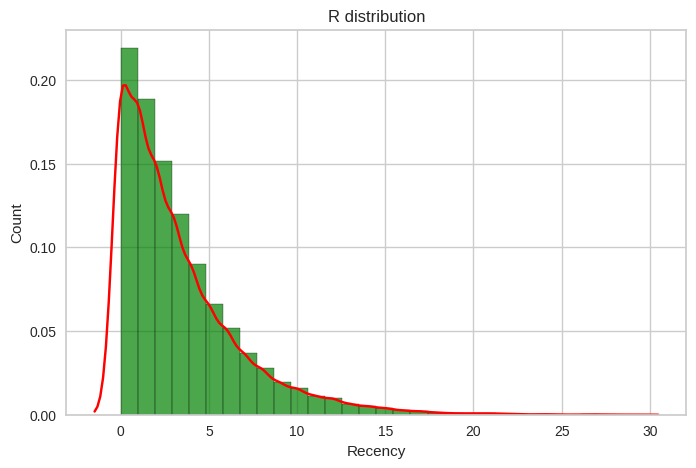

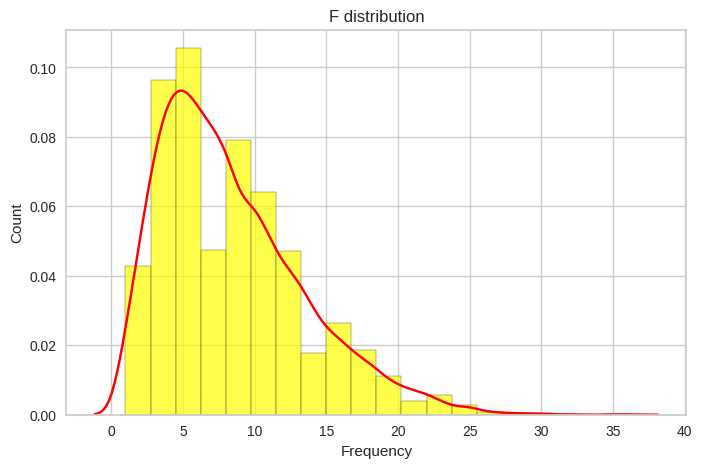

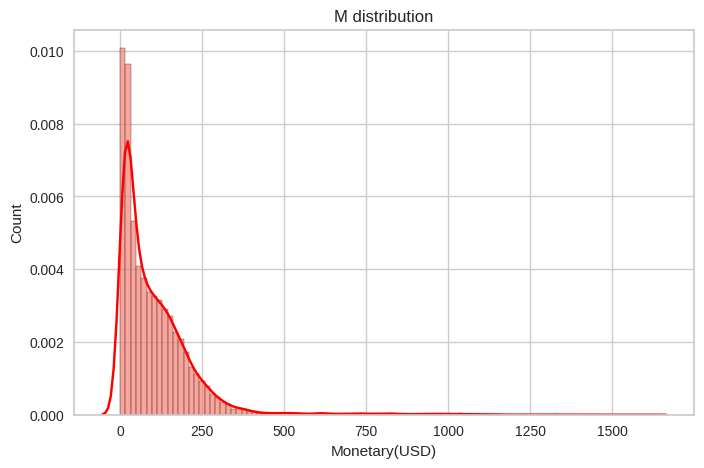

In [ ]:
def RFM_Plot(score, r=True, f=True, m=True):

    def plot_distribution(data, column, color, title, xlabel, ylabel):
        plt.figure(figsize=[8, 5])
        plt.hist(data[column], bins=30 if column == 'Recency' else 20 if column == 'Frequency' else 100,
                 color=color, edgecolor='black', density=True, alpha=0.7)
        sns.kdeplot(data[column], color='red')
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

    if r:
        plot_distribution(score, 'Recency', 'green', 'R distribution', 'Recency', 'Count')

    if f:
        plot_distribution(score, 'Frequency', 'yellow', 'F distribution', 'Frequency', 'Count')

    if m:
        plot_distribution(score, 'Monetary', 'salmon', 'M distribution', 'Monetary(USD)', 'Count')

    plt.show()

RFM_Plot(rfm_scores)


Dựa trên các biểu đồ trên, chúng ta có thể thấy rằng các giá trị R, F, M bị lệch phải.

Nói cách khác là phân khúc khách hàng ở tầm thấp nhiều hơn khách hàng cao cấp


![](https://www.asquareschool.com/wp-content/uploads/2015/08/skewness.jpg)

### Modeling

<ipython-input-30-5d8ecca2a301>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(rfm_scores.iloc[:,0:4].corr() , annot=True )


Text(0.5, 1.0, 'Correlation Heatmap')

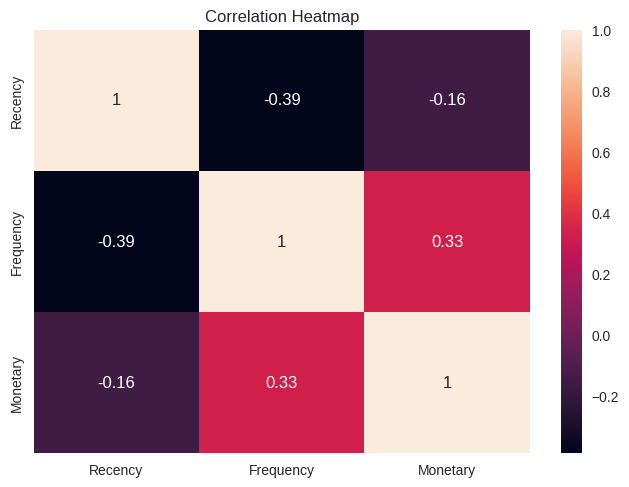

In [ ]:
sns.heatmap(rfm_scores.iloc[:,0:4].corr() , annot=True )
plt.title('Correlation Heatmap')

Dễ thấy:
- F và M tương quan cao - Khách hàng quay lại càng nhiều lần đem đến doanh thu càng cao.
- R và M tỷ lệ nghịch - Những khách hàng ít ghé mua đem đến doanh số bán hàng thấp.

Không thể thực hiện Clustering ngay trên dữ liệu bị lệch trái và có chứa nhiều chuỗi ID (không phải dạng numeric).

Chúng ta cần chuẩn hóa dữ liệu về dạng dễ làm việc hơn.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import silhouette_visualizer, SilhouetteVisualizer, kelbow_visualizer

In [ ]:
scaler = MinMaxScaler()
rfm_normalized = pd.DataFrame(scaler.fit_transform(rfm_scores[['Recency', 'Frequency', 'Monetary']]))
rfm_normalized.columns = ['Recency', 'Frequency', 'Monetary']

 Sử dụng phương pháp Elbow để chọn số lượng cluster phù hợp.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

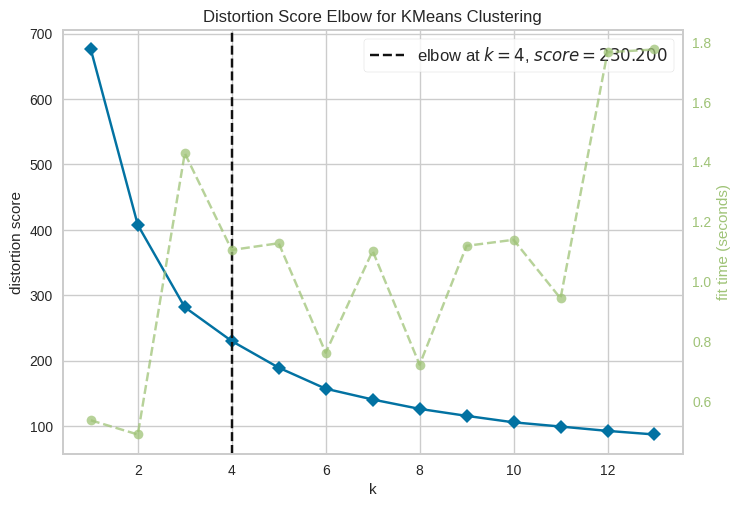

In [ ]:
kelbow_visualizer(KMeans(), rfm_normalized, k=(1,14));

Ý tưởng là chọn k mà khi tăng k lên, độ giảm của distortion không đáng kể nữa, và đó là lúc k được chọn.

### Chấm điểm R-F-M

Phân nhóm khách hàng bằng score of RFM:
- Chia khoảng cách thành các phân đoạn và gán điểm cho mỗi phân đoạn (ví dụ: 1-30 ngày = 5 điểm, 31-60 ngày = 4 điểm, và cứ tiếp tục).
- Chia số lần mua hàng thành các phân đoạn và gán điểm cho mỗi phân đoạn (ví dụ: 1-5 lần = 3 điểm, 6-10 lần = 4 điểm, và cứ tiếp tục).
- Chia tổng giá trị thành các phân đoạn và gán điểm cho mỗi phân đoạn (ví dụ: 0-100 USD = 2 điểm, 101-200 USD = 3 điểm, và cứ tiếp tục).

In [ ]:
def create_rfm_scores(df):
    """
    Input:
    - df: DataFrame chứa các cột Recency, Frequency, và Monetary.

    Returns:
    - DataFrame mới với các cột 'r_score', 'f_score', và 'm_score'.
    """

    # Tạo nhãn cho nhóm Recency, Frequency, và Monetary dựa trên quantiles
    labels = {'Recency': range(4, 0, -1), 'Frequency': range(1, 5), 'Monetary': range(1, 5)}

    for col in ['Recency', 'Frequency', 'Monetary']:
        groups = pd.qcut(df[col], q=4, labels=labels[col])
        df[f'{col[0].lower()}_score'] = pd.DataFrame(groups)

    return df

In [ ]:
rfm_df = create_rfm_scores(rfm_scores)

In [ ]:
rfm_df.head()

,Customer ID,Recency,Frequency,Monetary,r_score,f_score,m_score
7887,79d9d4f86aca4bed9290350fb43817c2,0,36,173.41,4,4,4
9702,94de646f7b6041228ca7dec82adb97d2,0,35,90.23,4,4,3
10740,a42ed50acc4d4b25bca647c9e0b916ad,0,31,461.09,4,4,4
11192,ab25fd6fbd5040f880751921e4029757,0,30,717.21,4,4,4
13558,d0a80415b84c4df4908b8403b19765e3,0,30,260.69,4,4,4


In [ ]:
print(rfm_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16578 entries, 7887 to 7764
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Customer ID  16578 non-null  object  
 1   Recency      16578 non-null  int64   
 2   Frequency    16578 non-null  int64   
 3   Monetary     16578 non-null  float64 
 4   r_score      16578 non-null  category
 5   f_score      16578 non-null  category
 6   m_score      16578 non-null  category
dtypes: category(3), float64(1), int64(2), object(1)
memory usage: 696.5+ KB
None


Thuật toán KMeans yêu cầu dữ liệu đầu vào là các giá trị số thực (numeric). Do đó, ta cần chuyển đổi các cột có kiểu dữ liệu category sang kiểu số thực

In [ ]:
# Chuyển đổi cột 'r_score' sang kiểu numeric
rfm_df['r_score'] = rfm_df['r_score'].astype('int')
rfm_df['f_score'] = rfm_df['f_score'].astype('int')
rfm_df['m_score'] = rfm_df['m_score'].astype('int')

Biểu đồ "elbow" thường có hình dạng giống một khuỷu tay, và điểm "elbow" (cù chỏ) trên biểu đồ thường là số lượng clusters tốt nhất. Tại đây nếu ta thêm một cluster nữa thì không cải thiện đáng kể độ chia nhóm - dựa trên khoảng cách euclide từ các điểm dữ liệu đến trung tâm của cluster gần nhất.

$EuclideanDistance =  \sum \limits _{i=1} ^{n} (x_{i} - y_{i})^2$

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
data = rfm_df.iloc[:, 4:7]
kmeans.fit(data)
rfm_df['rfm_cluster'] = kmeans.predict(data)
centers = kmeans.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<ipython-input-40-dc6508578915>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_data['rfm_cluster'] = kmeans.labels_


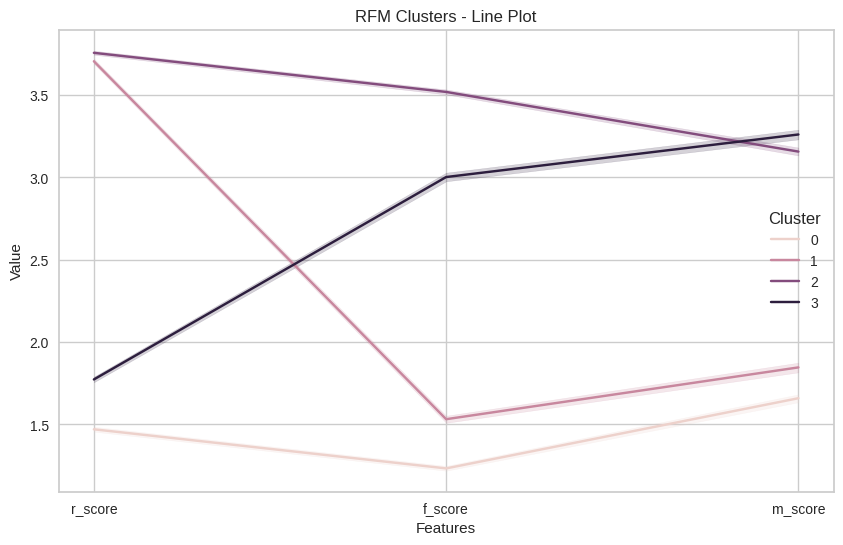

In [ ]:
# Bước 1: Chọn dữ liệu và gán nhãn cụm từ mô hình KMeans
rfm_data = rfm_df[['r_score', 'f_score', 'm_score']]
rfm_data['rfm_cluster'] = kmeans.labels_

# Bước 2: Melt DataFrame để chuẩn bị cho việc vẽ biểu đồ
melted_rfm = pd.melt(rfm_data, id_vars=['rfm_cluster'],
                     value_vars=['r_score', 'f_score', 'm_score'],
                     var_name='Features', value_name='Value')

# Bước 3: Vẽ biểu đồ đường
plt.figure(figsize=[10, 6])
sns.lineplot(x='Features', y='Value', hue='rfm_cluster', data=melted_rfm)
plt.title('RFM Clusters - Line Plot')
plt.legend(title='Cluster')
plt.show()



Nhận xét:
- Cluster 0 (Khách hàng có giá trị thấp):
  + Recency thấp: Lâu không mua sắm.
  + Frequency thấp: Thường xuyên mua sắm thấp.
  + Monetary thấp: Chi tiêu thấp.
  + Nhóm này là những khách hàng có giá trị thấp, có thể cần chiến lược khuyến mãi để tăng giá trị.


- Cluster 1 (Khách hàng mới):

  + Recency cao: Khách hàng mới mua sắm.
  + Frequency thấp: Chưa thường xuyên mua sắm.
  + Monetary thấp: Chi tiêu thấp.
  + Nhóm này là những khách hàng mới, có thể cần chiến lược giữ chân và thúc đẩy sự thường xuyên mua sắm.

- Cluster 2 (Khách hàng tốt nhất):
  + Recency cao: Mua sắm gần đây.
  + Frequency cao: Thường xuyên mua sắm.
  + Monetary cao: Chi tiêu cao.
  + Nhóm này là những khách hàng có giá trị cao nhất và đang giữ liên lạc chặt chẽ.

- Cluster 3 (Khách hàng có giá trị cao nhưng có nguy cơ rời bỏ cao):

  + Recency thấp: Khách hàng mua sắm gần đây.
  + Frequency cao: Thường xuyên mua sắm.
  + Monetary cao: Chi tiêu cao.
  + Nhóm này có nguy cơ rời bỏ cao, có thể cần chú ý để giữ chân khách hàng.

In [ ]:
rfm_df['rfm_segment']= rfm_data['rfm_cluster'].copy()
rfm_df['rfm_segment'] = rfm_df['rfm_segment'].replace([0,1,2,3], ['High value/High risk','New Customer',
                                                                  'Best Customer','Low Value Customer'])

In [ ]:
rfm_df

,Customer ID,Recency,Frequency,Monetary,r_score,f_score,m_score,rfm_cluster,rfm_segment
7887,79d9d4f86aca4bed9290350fb43817c2,0,36,173.41,4,4,4,2,Best Customer
9702,94de646f7b6041228ca7dec82adb97d2,0,35,90.23,4,4,3,2,Best Customer
10740,a42ed50acc4d4b25bca647c9e0b916ad,0,31,461.09,4,4,4,2,Best Customer
11192,ab25fd6fbd5040f880751921e4029757,0,30,717.21,4,4,4,2,Best Customer
13558,d0a80415b84c4df4908b8403b19765e3,0,30,260.69,4,4,4,2,Best Customer
...,...,...,...,...,...,...,...,...,...
6978,6ba58d2b211847d999213ea0b56b7f6a,26,1,25.07,1,1,2,0,High value/High risk
14675,e20a018d829b41e5a01e46d71a6dd009,27,3,52.66,1,1,2,0,High value/High risk
5957,5bf1841520a24a789b8addd9b383dad1,27,1,17.69,1,1,1,0,High value/High risk
16227,fa6335ecdd5744dfbf4cbdfcae5414fd,27,1,15.45,1,1,1,0,High value/High risk


In [ ]:
rfm_df.groupby('rfm_segment').agg({
    'Recency': ['count','mean', 'median','min','max'],
    'Frequency': ['count','mean', 'median','min', 'max'],
    'Monetary': ['count','mean', 'median','min', 'max']
})

Recency                          Frequency             \
                       count      mean median min max     count       mean   
rfm_segment                                                                  
Best Customer           5407  0.825412    1.0   0   2      5407  12.911041   
High value/High risk    4456  6.807899    6.0   3  29      4456   4.082361   
Low Value Customer      3243  4.637064    4.0   2  18      3243  10.134135   
New Customer            3472  0.934908    1.0   0   2      3472   5.209389   

                                    Monetary                              \
                     median min max    count        mean   median    min   
rfm_segment                                                                
Best Customer          12.0   6  36     5407  161.883266  144.770  12.91   
High value/High risk    4.0   1  11     4456   38.623153   21.425   0.05   
Low Value Customer      9.0   2  29     3243  166.951230  145.970  14.43   
New Customer            5.0   1  11     3472   53.750444   26.095   0.05   

                               
                          max  
rfm_segment                    
Best Customer         1608.69  
High value/High risk   150.63  
Low Value Customer    1327.74  
New Customer          1153.11

In [ ]:
def plot_data(df,demo,groupby, col_wrap,height,label_rotation):

    """
    This procedue is used to create aggregate measures per demographic group, and then plot those measures in plot

    INPUT:

    -Data input
    --df: input profile_offer dataframe with the measures to be aggrigated.
    --demo: input profile_offer dataframe
    --groupby: input the domographic group you want to aggrigate for

    -Variables for Data visualization
    --palette: Input the No of color palatte for the bar plot
    --col_wrap: Input th enumber of column in the grid
    --height: Input the height of the plot
    --label_rotation: Input degrees to which X-axis labels need to be rotated.


    OUTPUT:
    - df: return dataframe with te aggregated measures and the plot

    """

    #Aggrigate measure(sum) grouped by demographics
    df = df.join(demo[groupby])
    df = df.copy().reset_index()
    df = df.melt(id_vars=['Customer ID', groupby],ignore_index = True)
    df = df.groupby([groupby, 'variable']).mean().reset_index()
    df = df[df['variable']!='index']


    #Plot and visualize data in a grid
    g = sns.FacetGrid(df, col='variable', hue= groupby, col_wrap=col_wrap, height=height, sharey=False)
    g = g.map(plt.bar, groupby, 'value').set_titles("{col_name}")
    g.set_xticklabels(rotation = label_rotation)
    g.tight_layout()

    #Return aggregate data grouped by demographic variable entered in 'groupby'
    return df

<ipython-input-44-70fdb10ed094>:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby([groupby, 'variable']).mean().reset_index()


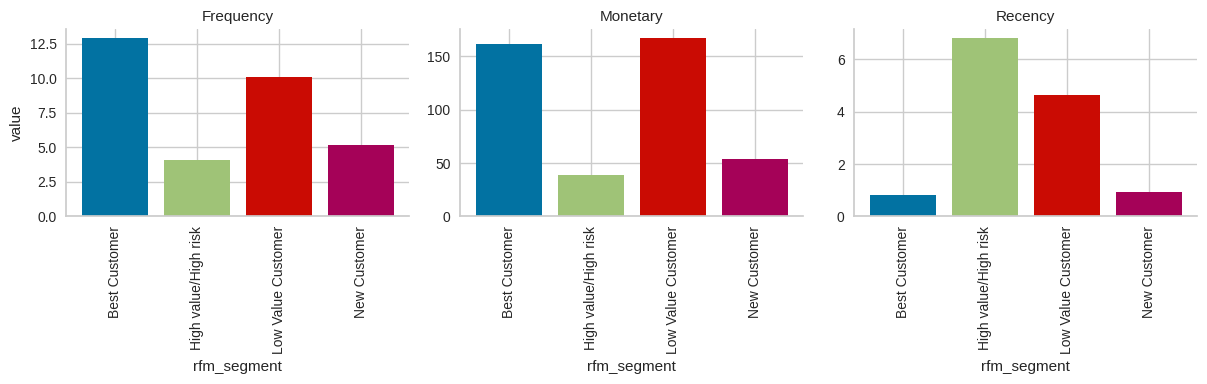

In [ ]:
rfm_da= rfm_df[['Customer ID','Recency','Frequency','Monetary']]
df_plot = plot_data(rfm_da,rfm_df,  groupby = 'rfm_segment',col_wrap=5,height=4,label_rotation = 90)

# FEATURE SELECTION

In [ ]:
profile = pd.read_csv('/content/cleaned_profile.csv',index_col=0)
profile

#Group the age ranges
labels = ['GenZ(18–25)', 'Millennias(26-43)', 'GenX(44-56)','Boomers(57-75)', 'Matures(76+)']
profile['age_group'] = pd.cut(profile['age'], bins=[18, 26, 44, 57, 76, 101] , labels=labels, include_lowest=True)

# Encode for Age ranges
profile_df = pd.get_dummies(profile['age_group'])

# Group by Income
bins_income = [1,50001,75001,100001,120001]
labels_income = ['Under $50k','$(50k-75k)','$(75k-100k)','$(100k-120k)']
profile['income'] = pd.to_numeric(profile['income'], errors='coerce')
profile['income_group']=pd.cut(profile['income'], bins=bins_income, labels = labels_income,right=False)

#Convert became_member_on
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y-%m-%d')
profile['year'] = profile['became_member_on'].dt.year.astype(str).str[:4]
profile=profile.drop('became_member_on', axis=1)

profile = profile.rename(columns={'person':'Customer ID', 'age_group': 'Age', 'gender': 'Gender', 'income_group': 'Income', 'year': 'MemberSince'})
reordered_columns = ['Customer ID', 'Gender', 'MemberSince', 'Age', 'Income']
profile  = profile[reordered_columns]
profile

,Customer ID,Gender,MemberSince,Age,Income
0,0610b486422d4921ae7d2bf64640c50b,F,2017,GenX(44-56),$(100k-120k)
1,78afa995795e4d85b5d9ceeca43f5fef,F,2017,Boomers(57-75),$(75k-100k)
2,e2127556f4f64592b11af22de27a7932,M,2018,Boomers(57-75),$(50k-75k)
3,389bc3fa690240e798340f5a15918d5c,M,2018,Boomers(57-75),$(50k-75k)
4,2eeac8d8feae4a8cad5a6af0499a211d,M,2017,Boomers(57-75),$(50k-75k)
...,...,...,...,...,...
14820,6d5f3a774f3d4714ab0c092238f3a1d7,F,2018,GenX(44-56),$(50k-75k)
14821,2cb4f97358b841b9a9773a7aa05a9d77,M,2018,Boomers(57-75),$(50k-75k)
14822,01d26f638c274aa0b965d24cefe3183f,M,2017,GenX(44-56),$(50k-75k)
14823,9dc1421481194dcd9400aec7c9ae6366,F,2016,Matures(76+),Under $50k


In [ ]:
model_df = pd.merge(rfm_scores, profile, on='Customer ID', how='inner')
model_df

,Customer ID,Recency,Frequency,Monetary,r_score,f_score,m_score,rfm_cluster,rfm_segment,Gender,MemberSince,Age,Income
0,79d9d4f86aca4bed9290350fb43817c2,0,36,173.41,4,4,4,2,Best Customer,M,2015,Boomers(57-75),Under $50k
1,94de646f7b6041228ca7dec82adb97d2,0,35,90.23,4,4,3,2,Best Customer,M,2014,Millennias(26-43),Under $50k
2,a42ed50acc4d4b25bca647c9e0b916ad,0,31,461.09,4,4,4,2,Best Customer,F,2016,Boomers(57-75),Under $50k
3,ab25fd6fbd5040f880751921e4029757,0,30,717.21,4,4,4,2,Best Customer,M,2015,Millennias(26-43),Under $50k
4,d0a80415b84c4df4908b8403b19765e3,0,30,260.69,4,4,4,2,Best Customer,M,2016,GenX(44-56),Under $50k
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14487,6ba58d2b211847d999213ea0b56b7f6a,26,1,25.07,1,1,2,0,High value/High risk,F,2018,Boomers(57-75),$(75k-100k)
14488,e20a018d829b41e5a01e46d71a6dd009,27,3,52.66,1,1,2,0,High value/High risk,F,2017,Millennias(26-43),$(50k-75k)
14489,5bf1841520a24a789b8addd9b383dad1,27,1,17.69,1,1,1,0,High value/High risk,F,2017,Matures(76+),$(75k-100k)
14490,fa6335ecdd5744dfbf4cbdfcae5414fd,27,1,15.45,1,1,1,0,High value/High risk,F,2018,Boomers(57-75),$(50k-75k)


In [ ]:
model_df = model_df.drop(['Customer ID' , 'rfm_segment'], axis=1)

In [ ]:
# Chuyển đổi biến phân loại (categorical variables) thành biến giả (dummy variables)
model_df_dummies = pd.get_dummies(model_df)
model_df_dummies

,Recency,Frequency,Monetary,r_score,f_score,m_score,rfm_cluster,Gender_F,Gender_M,Gender_O,...,MemberSince_2018,Age_GenZ(18–25),Age_Millennias(26-43),Age_GenX(44-56),Age_Boomers(57-75),Age_Matures(76+),Income_Under $50k,Income_$(50k-75k),Income_$(75k-100k),Income_$(100k-120k)
0,0,36,173.41,4,4,4,2,0,1,0,...,0,0,0,0,1,0,1,0,0,0
1,0,35,90.23,4,4,3,2,0,1,0,...,0,0,1,0,0,0,1,0,0,0
2,0,31,461.09,4,4,4,2,1,0,0,...,0,0,0,0,1,0,1,0,0,0
3,0,30,717.21,4,4,4,2,0,1,0,...,0,0,1,0,0,0,1,0,0,0
4,0,30,260.69,4,4,4,2,0,1,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14487,26,1,25.07,1,1,2,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0
14488,27,3,52.66,1,1,2,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
14489,27,1,17.69,1,1,1,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
14490,27,1,15.45,1,1,1,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0


In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
import pandas as pd

# Separate the independent variables (features) from the dependent variable (target)
X = model_df_dummies.drop('Monetary', axis=1)
y = model_df_dummies['Monetary']

# Create an instance of DecisionTreeRegressor
estimator = DecisionTreeRegressor()

# Create an instance of RFECV and pass in the estimator and number of cross-validation folds
selector = RFECV(estimator, cv=5)

# Fit the selector to the data with a progress bar
for i in tqdm(range(1, X.shape[1] + 1)):
    selector.n_features_ = i
    selector.fit(X, y)

# Get the mask of selected features
feature_mask = selector.support_

# Get the names of the selected features
selected_features = X.columns[feature_mask]

# Print the optimal number of features and their names
print("Optimal number of features: {}".format(selector.n_features_))
print("Selected features:")
for feature in selected_features:
    print(feature)

100%|██████████| 24/24 [02:42<00:00,  6.79s/it]

Optimal number of features: 2
Selected features:
Frequency
m_score


In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Prepare the data
X = model_df_dummies.drop('Monetary', axis=1)
y = model_df_dummies['Monetary']

# Define the models
mlr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elastic = ElasticNet()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
xgb = XGBRegressor()
svr = SVR()
lgbm = LGBMRegressor()
mlp = MLPRegressor()
kr = KernelRidge()
knn = KNeighborsRegressor()

# Define base estimators to be used in the ensemble
base_estimators = [('rf', RandomForestRegressor()),
                   ('xgb', XGBRegressor()),
                   ('dt', DecisionTreeRegressor())]

# Define a final estimator to combine the predictions of the base estimators
final_estimator = StackingRegressor(estimators=[('ridge', RidgeCV()),
                                                 ('lasso', LassoCV())])

# Define a StackingRegressor object with the base and final estimator
stacked = StackingRegressor(estimators=base_estimators, final_estimator=final_estimator)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Define the cross-validation strategy
cv = KFold(n_splits=5, shuffle=True)

# Fit and evaluate each model using cross-validation
models = {'MLR': mlr, 'Ridge': ridge, 'Lasso': lasso, 'Elastic Net': elastic, 'Decision Tree': dt, 'Random Forest': rf, 'XGBoost': xgb, 'SVR': svr, 'Stacked Ensemble': stacked, 'LGBM':lgbm, 'MLP':mlp, 'Kernel Ridge': kr, 'KNN': knn}

# Initialize variables to track the best model and its MAE
best_model_mae = None
best_mae = np.inf

metrics_dict = {}
for name, model in tqdm(models.items(), desc="Processing models"):
    metrics_dict[name] = []

    # Evaluate the model using cross-validation on the training set
    mae_train = -cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')

    # Evaluate the model on the test set
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    metrics_dict[name].extend([mae_train.mean(), mae_test])

    # Check if current model has lower MAE
    if mae_test < best_mae:
        best_model_mae = name
        best_mae = mae_test

# Create a DataFrame and print the results
metrics_df = pd.DataFrame(metrics_dict, index=['MAE Train', 'MAE Test']).T
metrics_df['MAE Train'] = metrics_df['MAE Train'].apply(lambda x: f'${x:.2f}')
metrics_df['MAE Test'] = metrics_df['MAE Test'].apply(lambda x: f'${x:.2f}')
metrics_df.index.name = 'Model'
print(metrics_df.to_string())

# Print the best model for MAE
print(f"\nBest Model (based on MAE): {best_model_mae}")

Processing models:  69%|██████▉   | 9/13 [03:20<03:32, 53.21s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 8115, number of used features: 24
[LightGBM] [Info] Start training from score 118.656951
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 8115, number of used features: 24
[LightGBM] [Info] Start training from score 120.423699
[LightGBM] [Warning] Found w

Processing models: 100%|██████████| 13/13 [05:27<00:00, 25.16s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 8115, number of used features: 24
[LightGBM] [Info] Start training from score 119.414149
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 8116, number of used features: 24
[LightGBM] [Info] Start training from score 118.670323
[LightGBM] [Warning] Found w

## CLV

![](https://blog.jump450.com/content/images/2020/01/ltv-1.png)

[Nguồn ảnh: blog.jump450.com](https://blog.jump450.com/content/images/2020/01/ltv-1.png)


Dự đoán chỉ số CLV cho phép phân loại khách hàng một cách hiệu quả dựa trên giá trị và hành vi, tạo điều kiện tối ưu trải nghiệm cá nhân và tăng hiệu quả giữ chân khách hàng, đồng thời còn tăng cường sự hài lòng và lòng trung thành của khách hàng đối với sản phẩm.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Prepare the data
X = model_df_dummies.drop('Monetary', axis=1)
y = model_df_dummies['Monetary']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, -1],
    'num_leaves': [31, 63, 127],
}

# Perform hyperparameter tuning using randomized search and cross-validation
model = LGBMRegressor()
random_search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=KFold(n_splits=5, shuffle=True),
                                   scoring='neg_mean_absolute_error')
random_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Train the best model on the entire training set
best_model.fit(X_train, y_train)

# Calculate quantiles
quantiles = [0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99]

# Calculate actual and predicted CLV quantiles on the test set
actual_clv_quantiles = np.quantile(y_test, quantiles)
predicted_clv_quantiles = np.quantile(best_model.predict(X_test), quantiles)

# Calculate evaluation metrics for each quantile
mae = []
mape = []

# Add tqdm progress bar
with tqdm(total=len(quantiles), desc="Calculating Metrics") as pbar:
    for i in range(len(quantiles)):
        # Select the data points within the quantile range
        if i == len(quantiles) - 1:
            quantile_mask = (y_test >= actual_clv_quantiles[i])
        else:
            quantile_mask = (y_test >= actual_clv_quantiles[i]) & (y_test <= actual_clv_quantiles[i + 1])
        quantile_X = X_test[quantile_mask]
        quantile_y = y_test[quantile_mask]

        # Calculate evaluation metrics for the quantile
        mae.append(mean_absolute_error(quantile_y, best_model.predict(quantile_X)))
        mape.append(np.mean(np.abs((quantile_y - best_model.predict(quantile_X)) / quantile_y)) * 100)

        # Update the tqdm progress bar
        pbar.update(1)

# Create a DataFrame with the results
results = pd.DataFrame({
    'Quantile': ['Bottom 20%', '20-40%', '40-60%', '60-80%', '80-90%', '90-95%', '95-99%'],
    'Avg. Actual CLV': actual_clv_quantiles.round(2),
    'Avg. Predicted CLV': predicted_clv_quantiles.round(2),
    'MAE': mae,
    'MAPE': mape
})

# Format the columns
results['Avg. Actual CLV'] = '$' + results['Avg. Actual CLV'].astype(str)
results['Avg. Predicted CLV'] = '$' + results['Avg. Predicted CLV'].astype(str)
results['MAE'] = results['MAE'].round(2)
results['MAPE'] = results['MAPE'].round(1).astype(str) + '%'

print("Best Model Parameters:")
print(best_params)

# Display the results DataFrame
results

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 8115, number of used features: 24
[LightGBM] [Info] Start training from score 118.757460
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

Calculating Metrics: 100%|██████████| 7/7 [00:00<00:00, 31.00it/s]

Best Model Parameters:
{'num_leaves': 63, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}


,Quantile,Avg. Actual CLV,Avg. Predicted CLV,MAE,MAPE
0,Bottom 20%,$25.53,$34.04,8.36,21.8%
1,20-40%,$62.84,$56.25,13.73,16.2%
2,40-60%,$118.98,$117.09,35.41,22.5%
3,60-80%,$184.64,$223.8,37.80,18.3%
4,80-90%,$241.02,$266.9,44.86,16.7%
5,90-95%,$304.67,$315.14,138.38,25.8%
6,95-99%,$841.66,$418.01,717.54,69.9%


Theo đánh giá MAE và MAPE, mô hình dự đoán có vẻ hoạt động tốt đối với các phân khúc CLV từ 20% đến 90%. Điều này là do sự phân phối không đồng đều của khách hàng, với một tỷ lệ cao hơn của khách hàng chi trả ít và tương đối ít khách hàng chi trả nhiều, dẫn đến một tín hiệu yếu từ những người chi trả nhiều. Do đó, mô hình cây gặp khó khăn trong việc xác định các mẫu ý nghĩa hoặc phân nhóm cụ thể liên quan đến số lượng ít hơn của khách hàng có giá trị cao, ảnh hưởng đến khả năng của nó trong việc nắm bắt chính xác hành vi của họ. Kết quả là, mô hình gặp khó khăn trong việc dự đoán các khách hàng có giá trị thấp nhất hoặc cao nhất.

## Insights and Actionable Recommendation

Việc xác định và giữ chân khách hàng có giá trị cao thường hiệu quả chi phí hơn so với việc thu hút khách hàng mới. Do đó cần lên chiến lược khuyến mãi và hậu mãi (Chăm sóc khách hàng) phù hợp cho phân khúc khách hàng có CLV cao.
